# Data Analysis of Siemens Web shop Revenues

## Task

You are requested to perform a data analysis and forecasting problem using the dataset provided.

The dataset is sourced from our foreign exchange and commodity risk team's foreign exchange (FX)
portfolio. 

Your task is to conduct an analysis of this data, while also generating insights for the future.



## Preprocess the data

### Apply setting 

In [2]:
# load libraries
import numpy as np
import pandas as pd
import sys, time, os
from datetime import date
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

# determine the path to the source folder
pth_to_src = 'C:/DEV/portfolio/src/'

# get date of today:
# Reason: Create outputfolder with current date to store plots and trained model if wanted.
today = '20230606' #date.today().strftime('%Y%m%d')

# input folder:
input_folder = pth_to_src + 'input/'

# output folder:
output_folder = pth_to_src + 'output/' + today + '/' # with date of today. This way a daily history of results can be automatically stored.
output_folder_plots = output_folder+'plots/'  
output_folder_model = output_folder+'model/'

# create output_folder if not existant:
os.makedirs(output_folder, exist_ok=True)
os.makedirs(output_folder_plots, exist_ok=True)
os.makedirs(output_folder_model, exist_ok=True)
# load utility functions
sys.path.append(pth_to_src+'/utils/')
from utility import *
# reload functions from utility
from importlib import reload
reload(sys.modules['utility'])

# set random seed for reproduceability
np.random.seed(888) 

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\G\anaconda3\envs\py311\Lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\G\anaconda3\envs\py311\Lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


### Load, clean, prepare and check the data

In [3]:
# Read the dataframe:
# ignore the empty column Bonuses and the redundant column System.
metrics = ['ChangeRequestCosts', 'AdministrationCosts', 'OverheadCosts', 'Interests', 'Revenue'] 
df = pd.read_excel(pth_to_src+'input/fx_portfolio.xlsx', parse_dates=['Date'], usecols = ['CCY', 'Date'] +metrics ) 
# fill in the values for the merged row cells for column CCY:
df.CCY = pd.Series(df.CCY).fillna(method='ffill')


In [4]:
# add Profit and cumulative profit
df['Profit'] = df[['ChangeRequestCosts', 'AdministrationCosts',
       'OverheadCosts', 'Interests', 'Revenue']].sum(axis=1)

#set date and CCY as index
df = df.set_index([df.Date, df.CCY])

# add _Total_  as sum of the currenies:
df1 = df.groupby(level='Date').sum(numeric_only=True)
df1['CCY'] = '_Total_'
df1['Date'] = df1.index
df1 = df1.set_index([df1.index, df1.CCY])
# append tota to df:
df = pd.concat([df, df1])
df = df.set_index([df.Date, df.CCY])

# calculate the cumulative profit:
df['CumulativeProfit']  = df['Profit'].groupby(level='CCY').cumsum()
metrics += ['Profit']

# add the year from :
df['year'] = df.Date.dt.year

# add the fiscal year from 10/10 until 09/30 of the next year:
# Reason: the data seems to be structured in this respective fiscal year.
df['fiscalYear'] = df.Date.dt.to_period('Q-SEP').astype(str).str.extract('(?P<year>\d+)')

df.head(4)

,,CCY,Date,ChangeRequestCosts,AdministrationCosts,OverheadCosts,Interests,Revenue,Profit,CumulativeProfit,year,fiscalYear
Date,CCY,,,,,,,,,,,
2019-10-01,EUR,EUR,2019-10-01,0.0,0.0,-479.45,89.00,16749.79,16359.34,16359.34,2019,2020
2019-10-02,EUR,EUR,2019-10-02,0.0,0.0,-419.33,80.92,97028.32,96689.91,113049.25,2019,2020
2019-10-03,EUR,EUR,2019-10-03,0.0,0.0,-446.22,105.12,20628.55,20287.45,133336.70,2019,2020
2019-10-04,EUR,EUR,2019-10-04,0.0,0.0,0.00,125.52,17327.73,17453.25,150789.95,2019,2020


In [5]:
# Show the number of rows and columns of the dataframe:
df.shape

(3920, 11)

In [6]:
# repalce the entries with missing values rows with zeros
# Reason: for some day there is no cashflow recored. So the cashflows are zero at these days. We may want to keep a data set with full records of daily observations within a week. Doing so can allow us to account for a seasonal trends later on.
print('Number of missing observations with missing data before filling in: %s'%sum(df[metrics].isna().any(axis=1)))
df = df.fillna(0)
print('Number of missing observations with missing data after  filling in: %s'%sum(df[metrics].isna().any(axis=1)))


Number of missing observations with missing data before filling in: 16
Number of missing observations with missing data after  filling in: 0


In [7]:
# Check the number of missing values of each column:
pd.DataFrame([df.isna().sum(),df.isna().mean()],index=['Number of missing values', 'Rate of missing values']).T

,Number of missing values,Rate of missing values
CCY,0.0,0.0
Date,0.0,0.0
ChangeRequestCosts,0.0,0.0
AdministrationCosts,0.0,0.0
OverheadCosts,0.0,0.0
Interests,0.0,0.0
Revenue,0.0,0.0
Profit,0.0,0.0
CumulativeProfit,0.0,0.0
year,0.0,0.0


In [8]:
# Show basic summary statistics of the data:
df.describe()

,ChangeRequestCosts,AdministrationCosts,OverheadCosts,Interests,Revenue,Profit,CumulativeProfit,year
count,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3920.000000,3.920000e+03,3920.000000
mean,-1135.364653,-190.959653,-182.248291,793.951352,12622.722505,11908.101260,4.368011e+06,2020.746173
std,5880.314972,943.247451,253.829884,3040.191015,26466.279294,26832.424068,6.568475e+06,0.924896
min,-56578.400000,-6098.970000,-1441.100000,-4144.080000,0.000000,-48500.090000,-5.068346e+04,2019.000000
25%,0.000000,0.000000,-307.087500,-0.520000,63.387500,24.775000,1.804121e+04,2020.000000
50%,0.000000,0.000000,-41.795000,24.865000,653.900000,766.225000,1.916453e+05,2021.000000
75%,0.000000,0.000000,0.000000,188.215000,12296.157500,11242.890000,8.384901e+06,2021.000000
max,0.000000,0.000000,0.000000,37312.230000,207016.190000,204689.240000,2.333988e+07,2022.000000


In [9]:
# Show frequency table per CCY and year  in the data set:
year_freq =df.copy().drop(columns=['CCY']).groupby(['fiscalYear','CCY']).size() 
year_freq.columns =['Count']
year_freq

fiscalYear  CCY    
2020        CHF        262
            EUR        262
            GBP        262
            USD        262
            _Total_    262
2021        CHF        261
            EUR        261
            GBP        261
            USD        261
            _Total_    261
2022        CHF        261
            EUR        261
            GBP        261
            USD        261
            _Total_    261
dtype: int64

In [10]:
# Show key metrics per year and CCY:
metrics_per_year_CCY = df[['fiscalYear']+metrics].groupby(['fiscalYear','CCY']).sum()
pd.options.display.float_format =  '{:,.0f}'.format
metrics_per_year_CCY

ChangeRequestCosts  AdministrationCosts  OverheadCosts  \
fiscalYear CCY                                                               
2020       CHF                       0               -1,244        -12,550   
           EUR                -655,258              -98,845        -50,849   
           GBP                 -47,964               -1,240        -35,190   
           USD                 -67,365               -6,273        -22,526   
           _Total_            -770,586             -107,602       -121,116   
2021       CHF                       0               -2,687        -12,114   
           EUR                -571,753             -119,527        -56,331   
           GBP                 -87,968                 -266        -26,452   
           USD                 -68,339               -9,892        -25,787   
           _Total_            -728,060             -132,373       -120,685   
2022       CHF                       0               -4,203        -11,524   
           EUR                -590,816             -124,571        -55,926   
           GBP                 -80,285               -1,461        -26,429   
           USD                 -55,568               -4,070        -21,527   
           _Total_            -726,669             -134,306       -115,406   

                    Interests   Revenue    Profit  
fiscalYear CCY                                     
2020       CHF        -23,222     4,208   -32,807  
           EUR          4,809 8,128,631 7,328,488  
           GBP         14,030    95,643    25,279  
           USD         35,630   174,483   113,948  
           _Total_     31,247 8,402,966 7,434,908  
2021       CHF          1,131     4,233    -9,437  
           EUR           -915 7,449,204 6,700,678  
           GBP         67,795    96,664    49,772  
           USD          7,342   167,046    70,369  
           _Total_     75,353 7,717,146 6,811,382  
2022       CHF          2,916     4,372    -8,439  
           EUR          1,602 8,337,958 7,568,247  
           GBP      1,432,479   106,787 1,431,091  
           USD         12,549   171,307   102,691  
           _Total_  1,449,545 8,620,424 9,093,588

In [11]:
# reset display settings
pd.reset_option('^display.', silent=True)

#### Plots per month

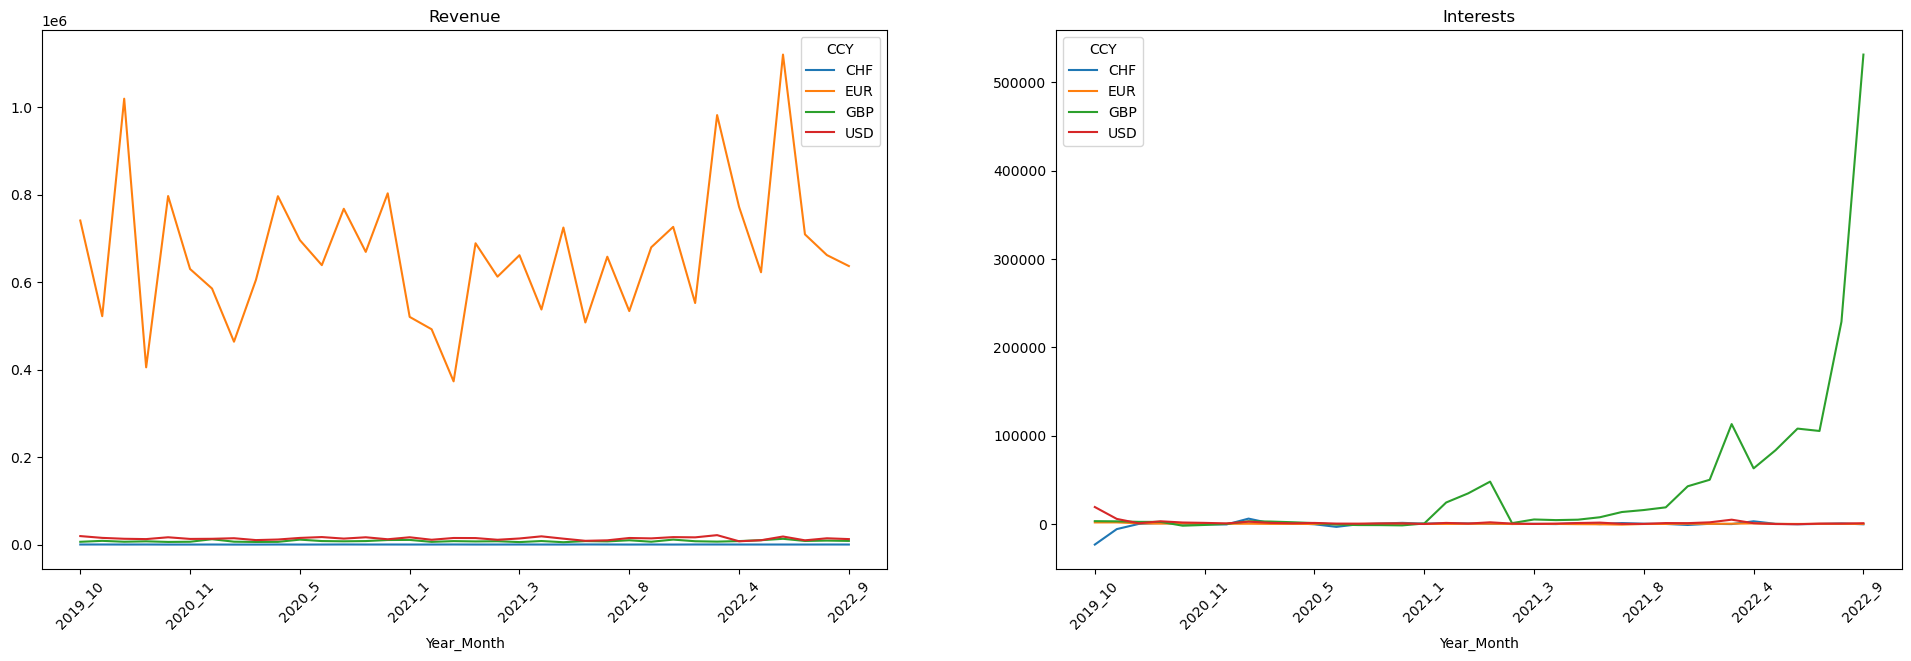

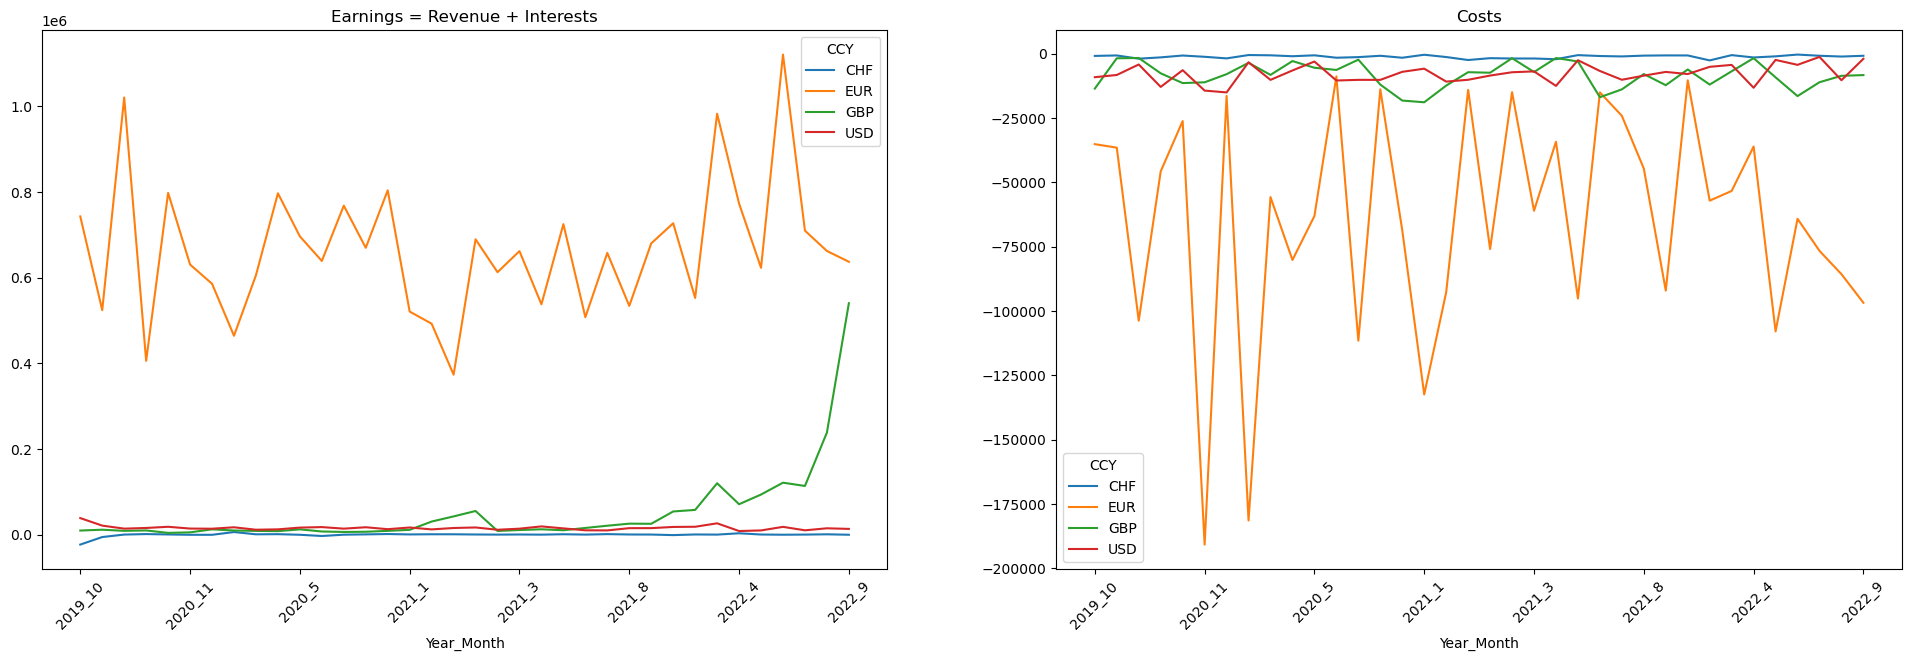

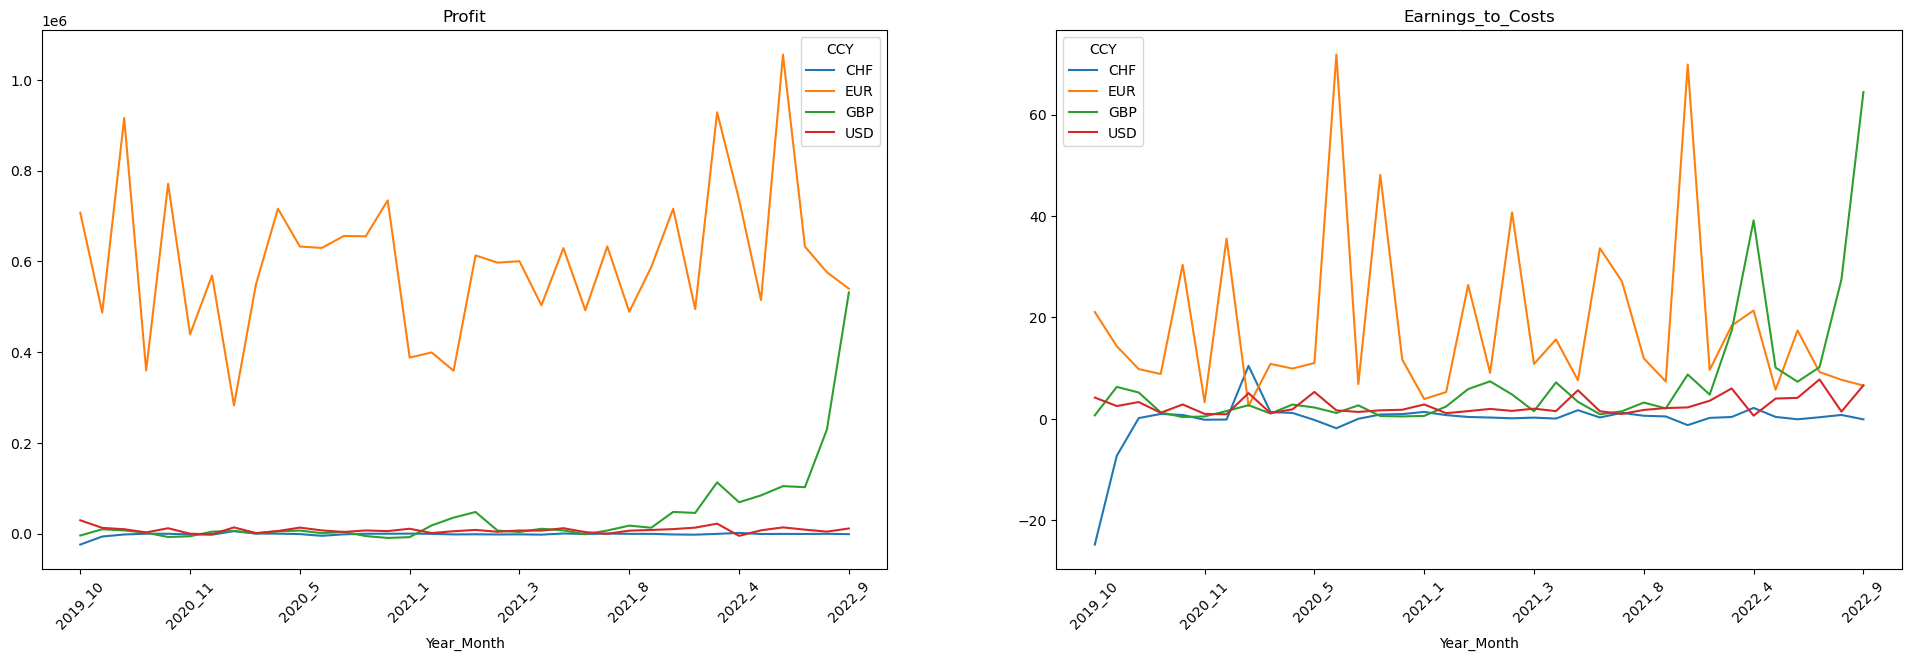

In [14]:
# plot descriptive graphs per month:
ratios_CCY = plot_descriptives_per_moth(df)

### Explorative analysis of the data

### Explorative plots 

#### Average daily values per fiscal year

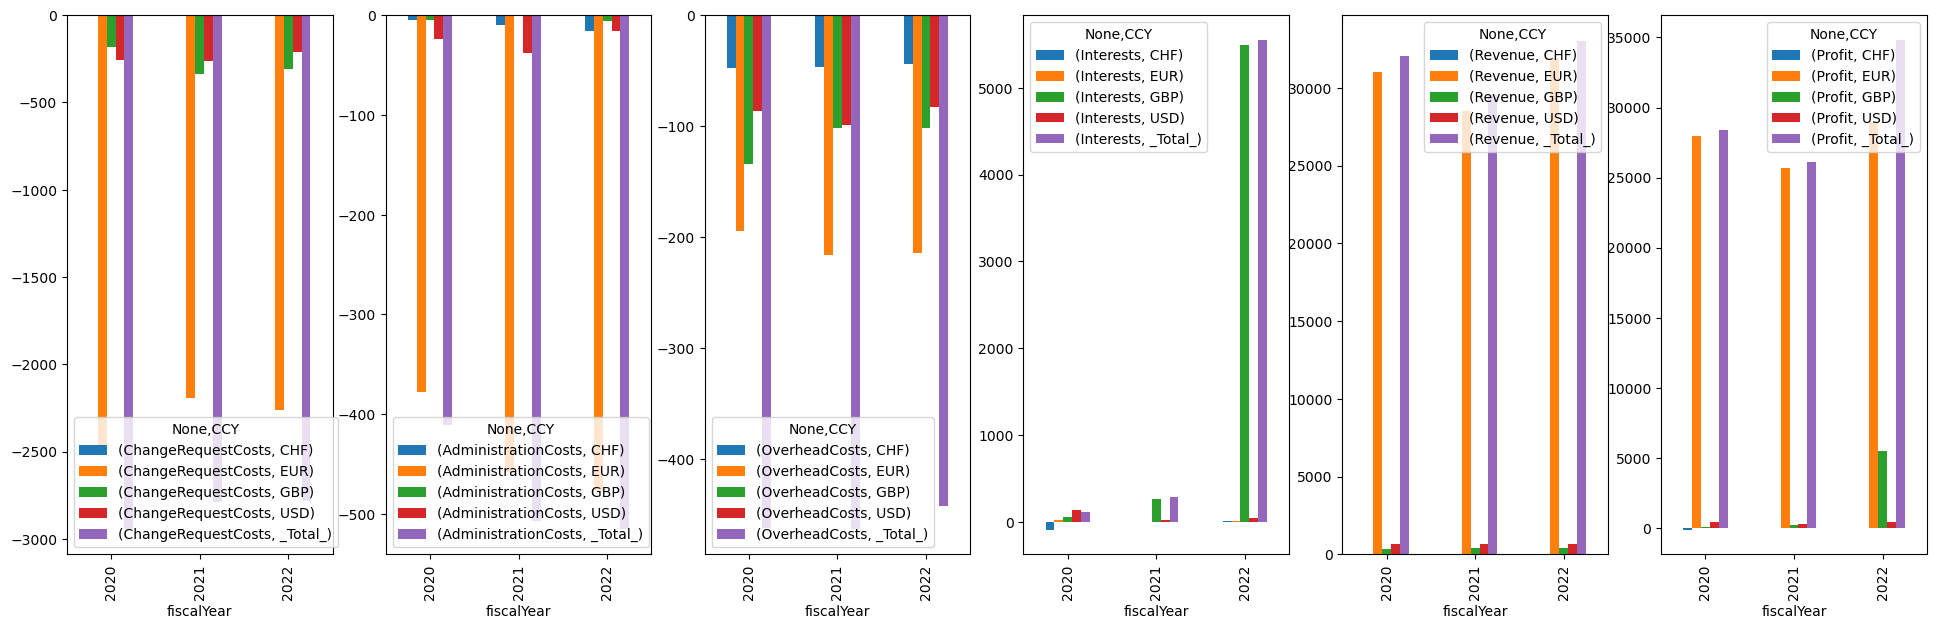

In [15]:
# Show barplots of mean metric values per year: 
fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize = (24, 7))
for i, m in enumerate(metrics):
    total_area_per_class = df[[m,'fiscalYear']].groupby(['fiscalYear','CCY']).mean()
    total_area_per_class.unstack().plot(kind='bar', ax= axs[i])


#### Boxplots of metrics per fiscal year 

Text(0.5, 0.98, 'Boxplots per fiscal year (for total across currencies)')

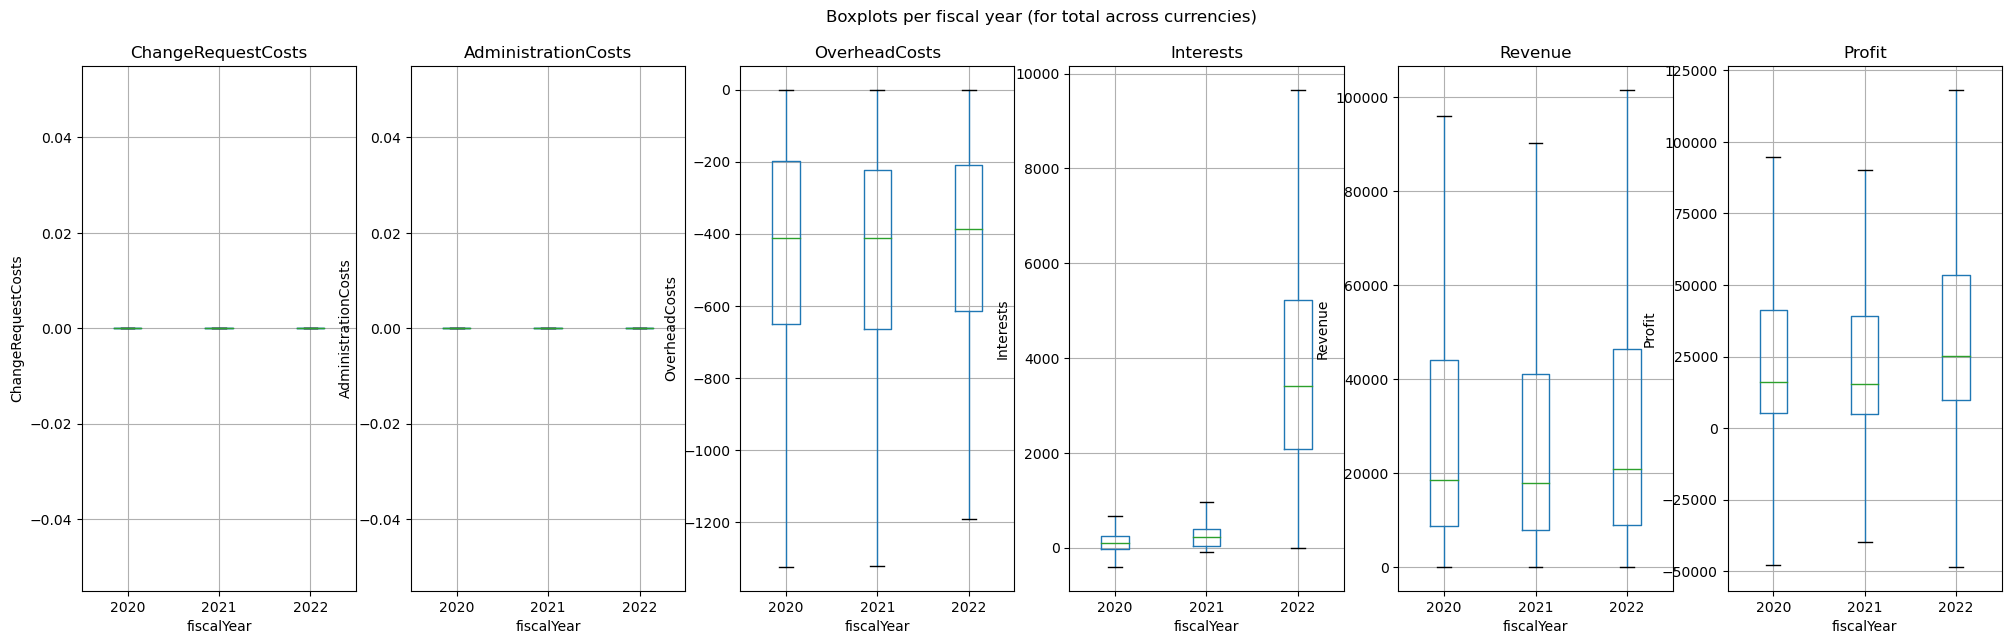

In [16]:
# Show boxplots of metrics per year: 
import seaborn as sns

fig, axs = plt.subplots(nrows=1, ncols=len(metrics), figsize = (24, 7))
for  i, m in enumerate(metrics):
    g = df.loc[df.CCY=='_Total_',[m,'fiscalYear']].boxplot(by=['fiscalYear'],showfliers=0, ax= axs[i])
    g.set_xlabel('fiscalYear'); g.set_ylabel(m)
fig.suptitle('Boxplots per fiscal year (for total across currencies)')

#### Plot the metrics per fiscal year across time

Text(0.5, 0.98, 'Plot per fiscal year (for total across currencies)')

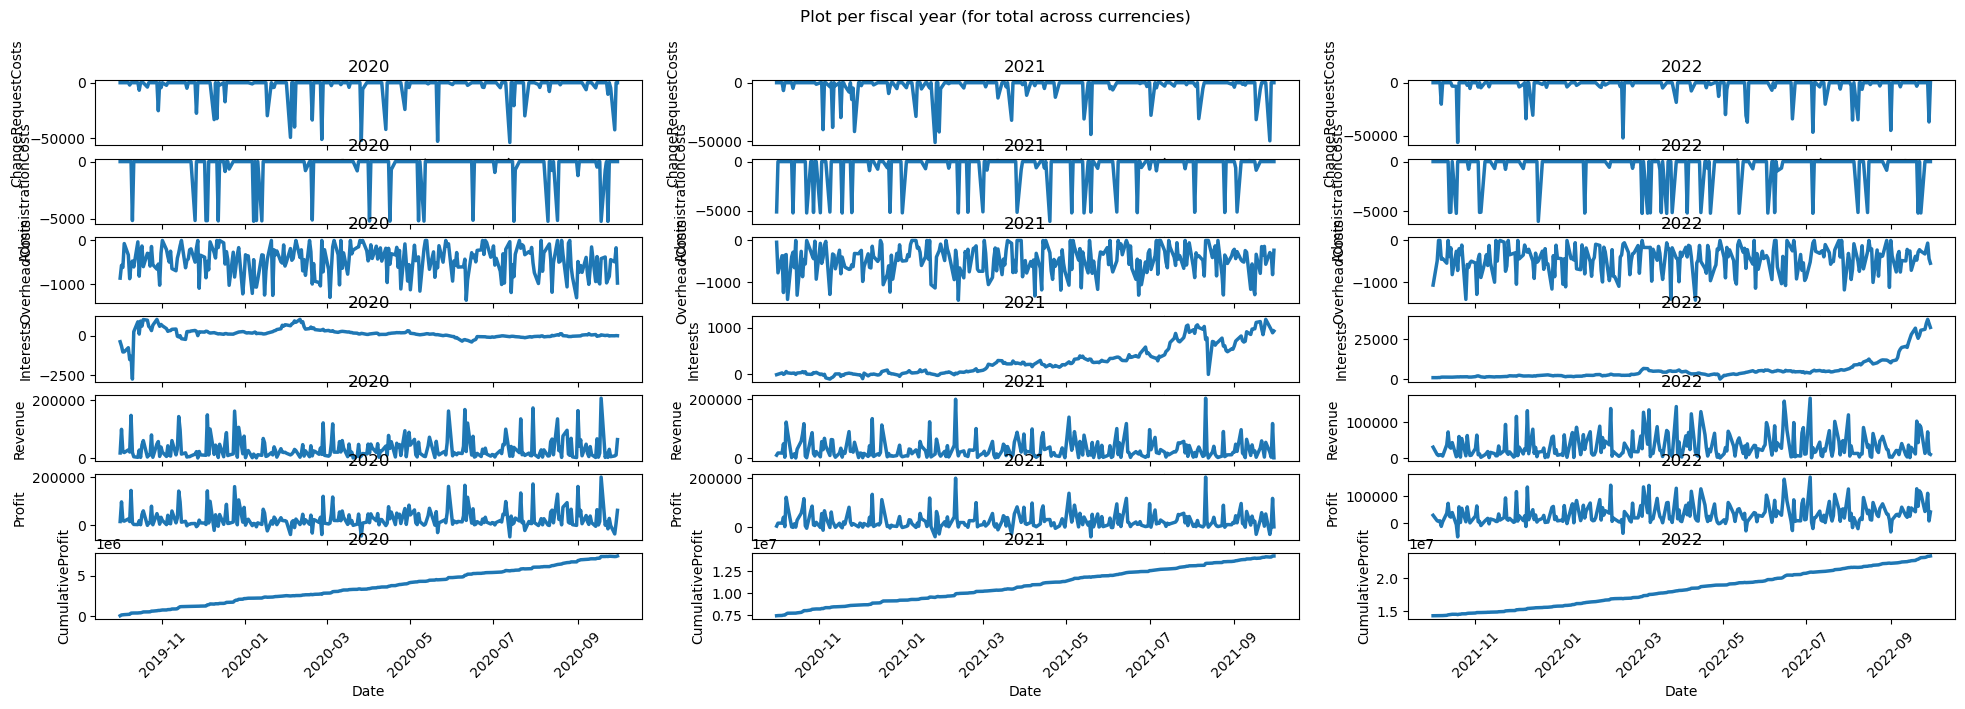

In [17]:
years = np.unique(metrics_per_year_CCY.index.get_level_values('fiscalYear'))
fig, axs = plt.subplots(nrows=len(metrics)+1, ncols=len(years), figsize = (24, 7))
for i, m in enumerate(metrics+['CumulativeProfit']):
    for j, c in enumerate(years):
        g = sns.lineplot(x='Date', y=m, data=df[(df.fiscalYear==c) & (df.CCY=='_Total_')], linewidth=2.5, ax= axs[i][j])
        axs[i][j].tick_params('x', labelrotation=45)
        g.set_title(c)
fig.suptitle('Plot per fiscal year (for total across currencies)')        

#### Autocorrelation of metrics

Text(0.5, 0.98, 'Plot per fiscal year (for total across currencies)')

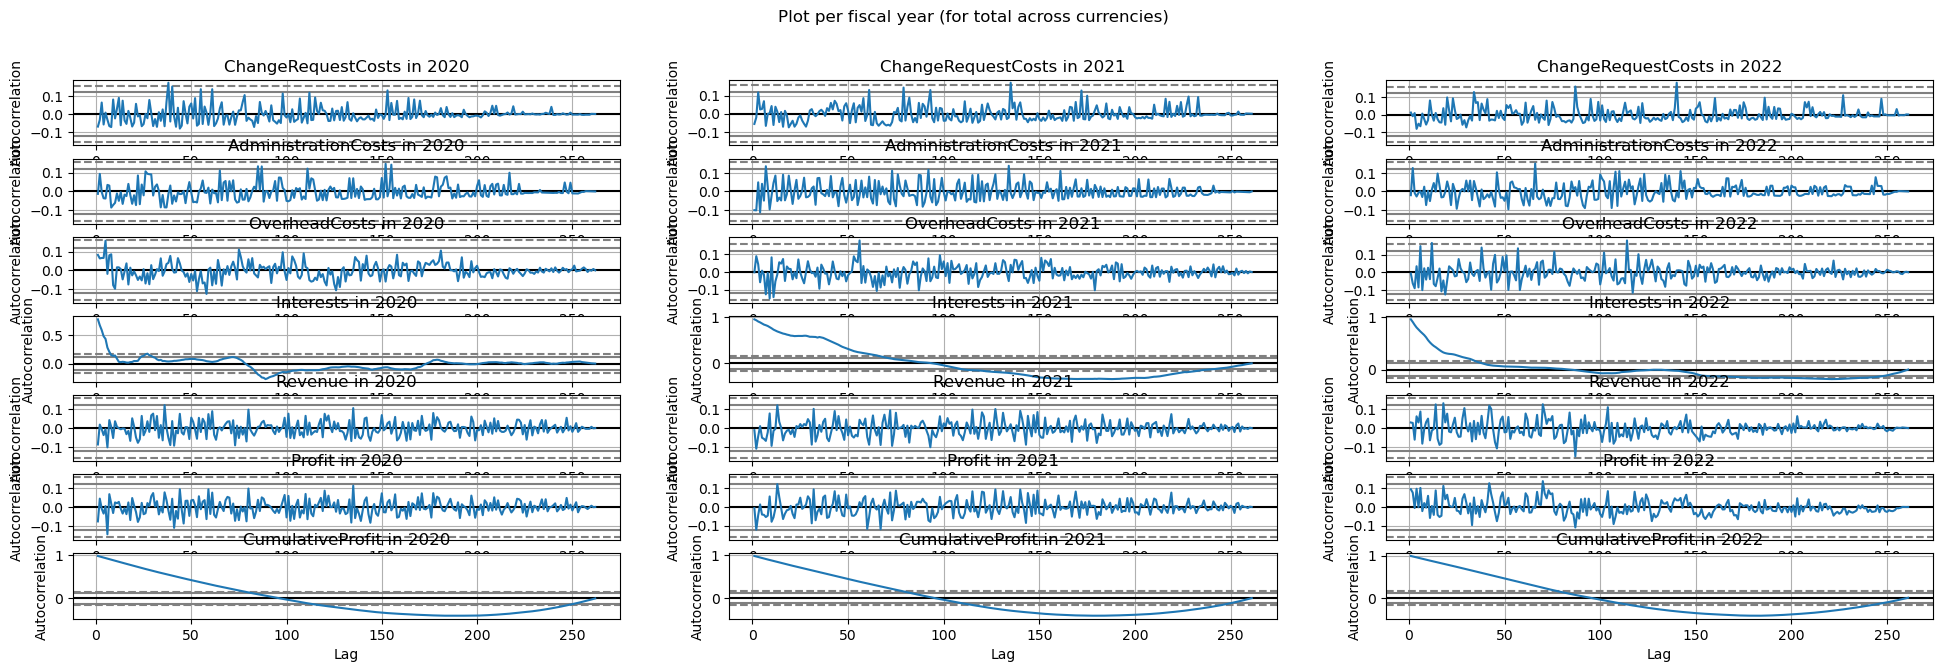

In [18]:
# Show autocorrelation plots
from pandas.plotting import autocorrelation_plot
years = np.unique(metrics_per_year_CCY.index.get_level_values('fiscalYear'))
fig, axs = plt.subplots(nrows=len(metrics)+1, ncols=len(years), figsize = (24, 7))
for i, m in enumerate(metrics+['CumulativeProfit']):
    for j, c in enumerate(years):
        autocorrelation_plot(df.loc[(df.fiscalYear==c) & (df.CCY=='_Total_'),m],ax= axs[i][j]) 
        axs[i][j].set_title(m+' in '+ str(c))
fig.suptitle('Plot per fiscal year (for total across currencies)')            

#### Decompostion of Revenue in Trend, Seasonal component and Residuals

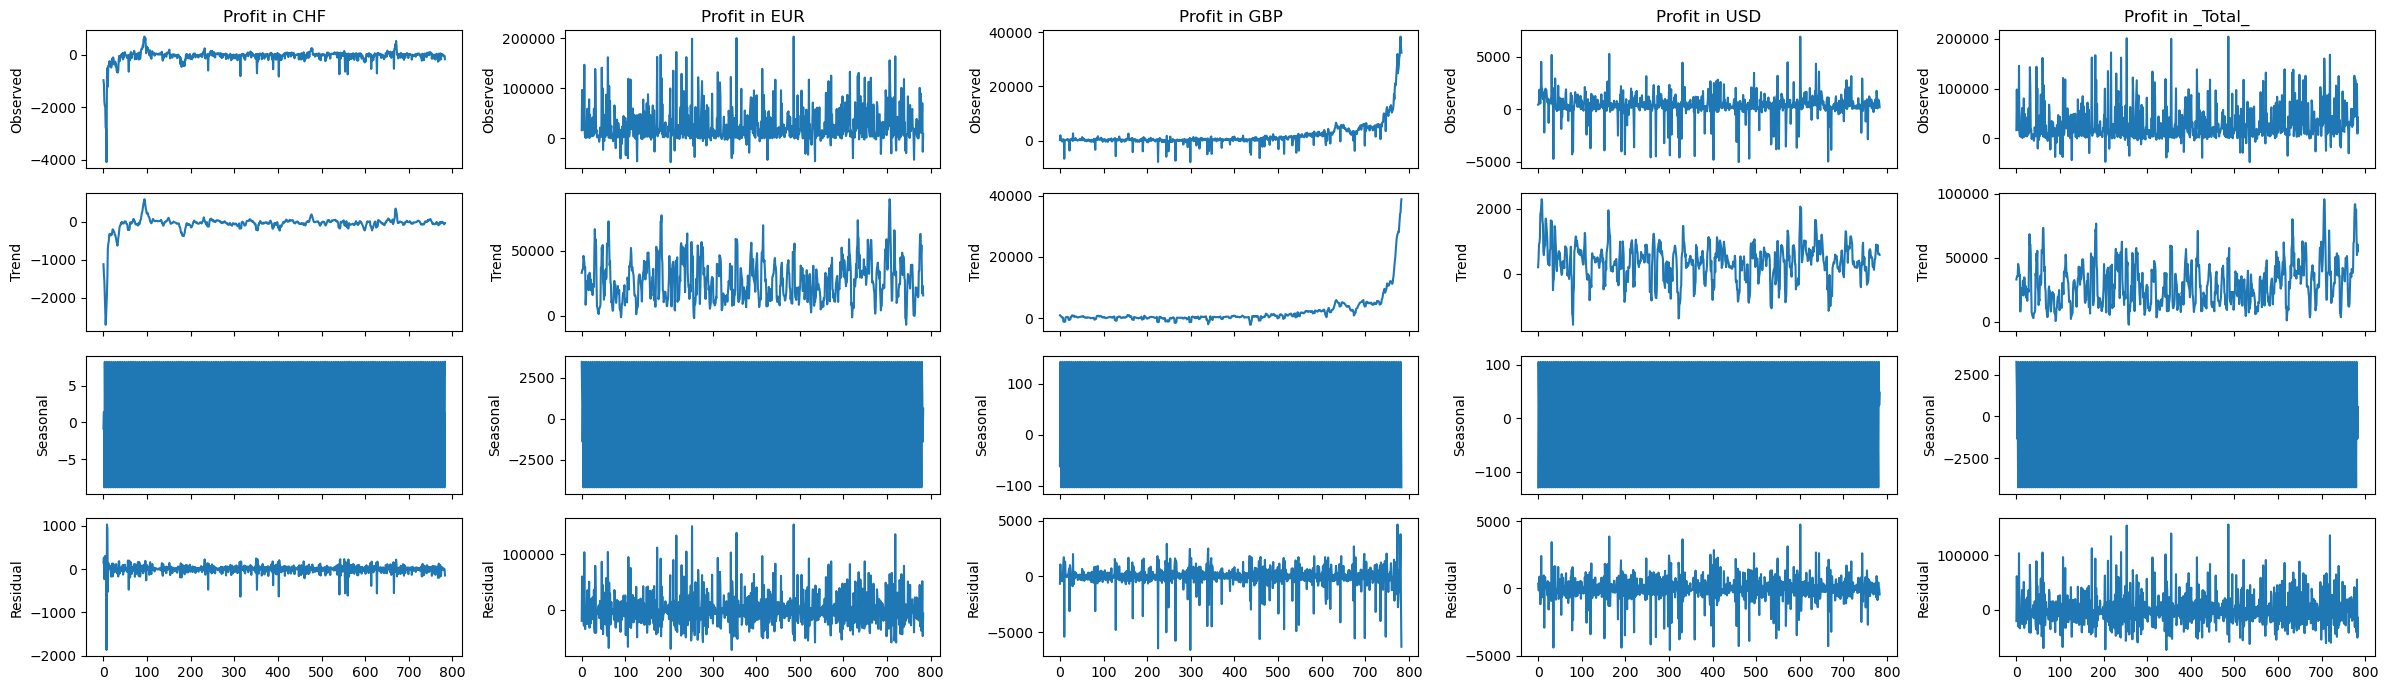

In [19]:
# use the custom function decompose_time_series:

_ = decompose_time_series(df, output_folder_plots = output_folder_plots,  y_var='Profit',  condition_variable = 'CCY')        

## Forcasting analysis

###  Prepare the data for the forcasting analysis

In [78]:
# prepare data
df1 = df.copy()

# Use cumulative profit as target variable for the forcast analyis
# Reasons: 
# - Cumulative profit is the variable of central interest.
# - Using lagged profit values and/or differencing can allow us to account for trends in the cumlative profit
# - Cumulative profit may be better suited to account for days of zero profit (e.g., due to days without observed cashflow records)

df1 = df1.rename(columns={'CumulativeProfit':'y_var'})

#set date and CCY as index
df1 = df1.set_index([df1.Date, df1.CCY])

#drop date and currency column
df1 = df1.drop(['year','fiscalYear','Date','CCY'], axis=1) 

x_vars = [i for i in df1.columns if i not in ['y_var']]
print(x_vars)


['ChangeRequestCosts', 'AdministrationCosts', 'OverheadCosts', 'Interests', 'Revenue', 'Profit']


In [79]:
# add lagged variables:
df1 = pd.merge(df1['y_var'], df1[x_vars+['y_var']].groupby(level='CCY').shift(1) ,left_index=True, right_index=True, suffixes=('', '_lagged1'))

# remove rows where all values are missing
# Reason: missing data due to using lagged values.
idx = pd.IndexSlice
mask = ~df1.isna().any(axis=1)
print('Number of observations before cleaning days of missing data: %s'%len(df1))
df1 = df1.loc[idx[mask, :, :], :]
print('Number of observations before cleaning days of missing data: %s'%len(df1))

# rename lagged variables
df1  = df1.rename(columns={i:i+'_lagged1' for i in x_vars})
x_vars = [i+'_lagged1' for i in x_vars]
print(df1.columns)

Number of observations before cleaning days of missing data: 3920
Number of observations before cleaning days of missing data: 3915
Index(['y_var', 'ChangeRequestCosts_lagged1', 'AdministrationCosts_lagged1',
       'OverheadCosts_lagged1', 'Interests_lagged1', 'Revenue_lagged1',
       'Profit_lagged1', 'y_var_lagged1'],
      dtype='object')


In [80]:
# split the data in a training and a test set:
horizon = 30
#take last week of the dataset for validation
inx_day = np.unique(df1.index.get_level_values('Date'))[-horizon]

df1_train, df1_test = df1.iloc[df1.index.get_level_values('Date')<inx_day], df1.iloc[df1.index.get_level_values('Date')>=inx_day]


#### Autoregressive moving average model

#### Differencing needed?

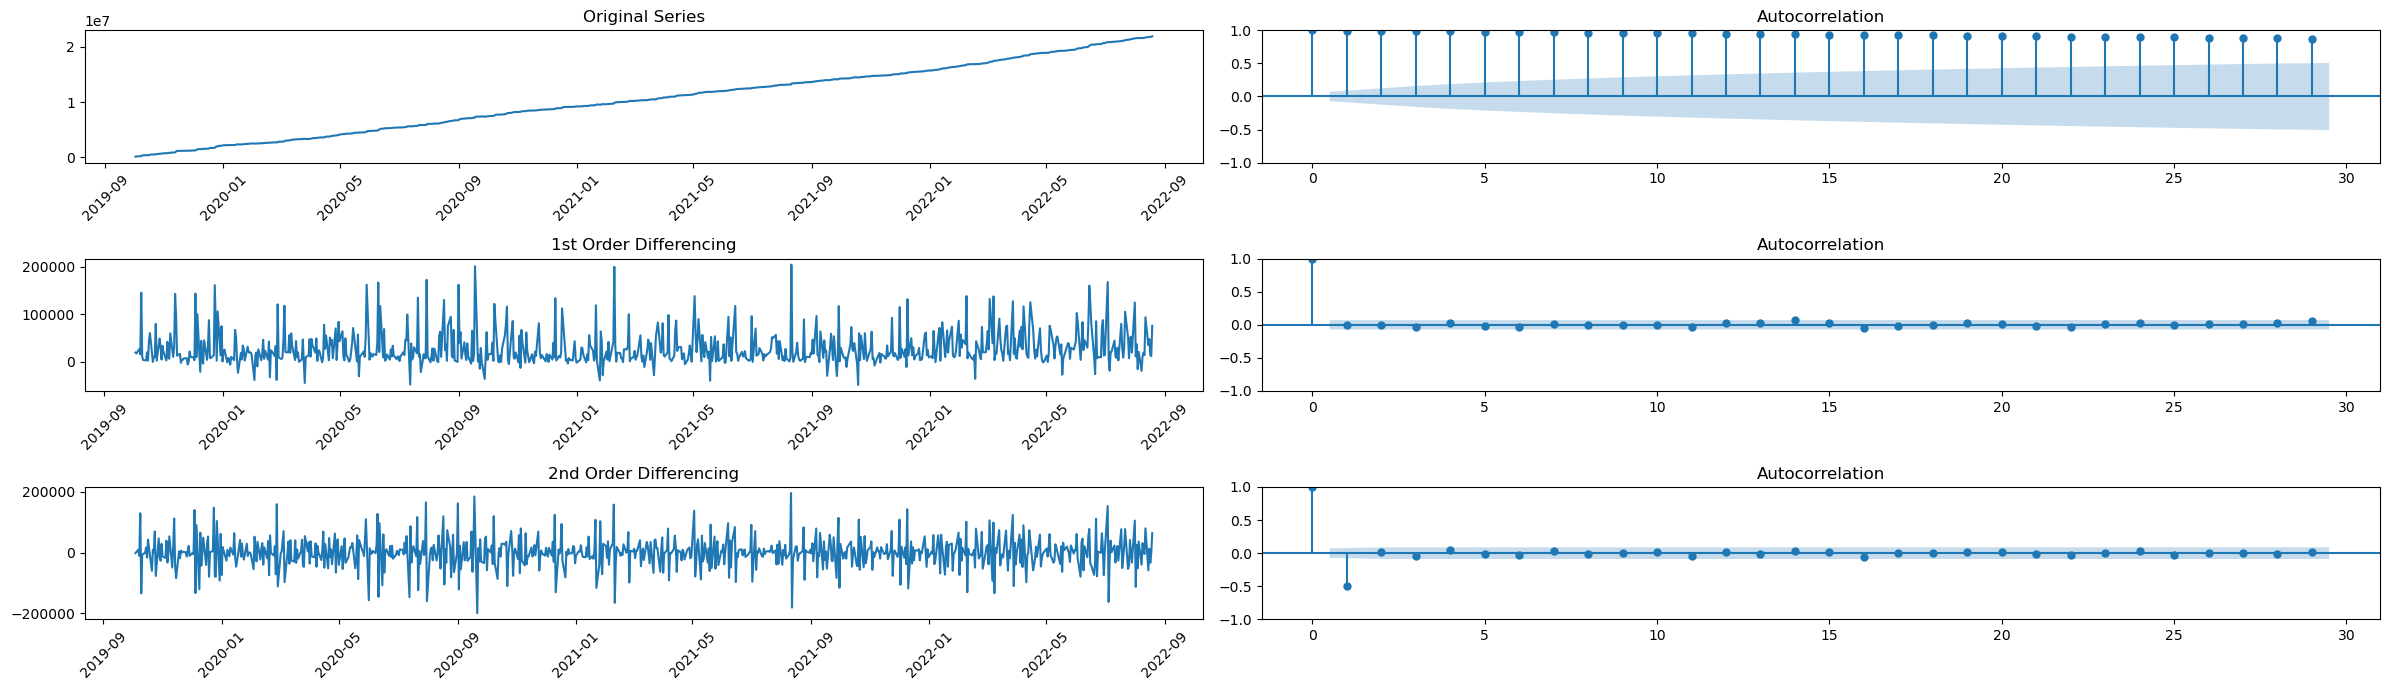

In [23]:
# visual inspection
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(24,7)}) 

y_train_total = df1_train[df1_train.index.get_level_values('CCY')=='_Total_'].y_var.droplevel('CCY')

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(y_train_total); axes[0, 0].set_title('Original Series')
axes[0, 0].tick_params('x', labelrotation=45)
plot_acf(y_train_total, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(y_train_total.diff()); axes[1, 0].set_title('1st Order Differencing')
axes[1, 0].tick_params('x', labelrotation=45)
plot_acf(y_train_total.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(y_train_total.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
axes[2, 0].tick_params('x', labelrotation=45)
plot_acf(y_train_total.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()


In [24]:
# run tests:
from pmdarima.arima.utils import ndiffs

## Adf Test
print(ndiffs(y_train_total, test='adf')  )

# KPSS test
print(ndiffs(y_train_total, test='kpss') ) 

# PP test:
print(ndiffs(y_train_total, test='pp')  )

1
2
1


Visual inspection and tests indicate that 1st order differencing is needed for a stationary time series. 

#### Autocorrelation?

[(0.0, 1.2)]

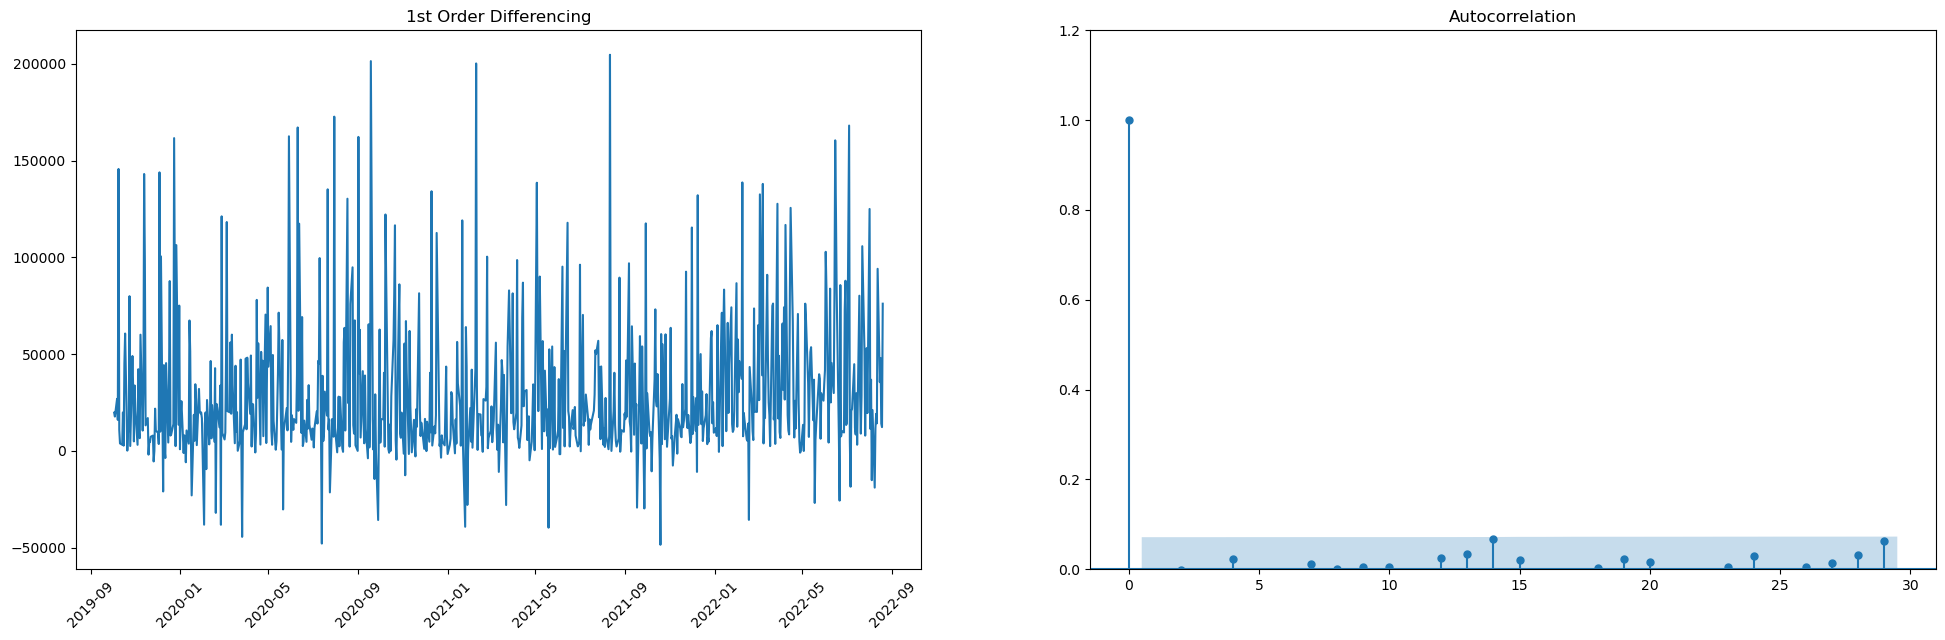

In [25]:
plt.rcParams.update({'figure.figsize':(24,7)})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_train_total.diff()); axes[0].set_title('1st Order Differencing')
plot_acf(y_train_total.diff().dropna(), ax=axes[1])
axes[0].tick_params('x', labelrotation=45)
axes[1].set(ylim=(0,1.2))

The autocorrelation plot does not indiate autocorrelation of the time series.

#### Partial Autocorrelation?

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


[(0.0, 5.0)]

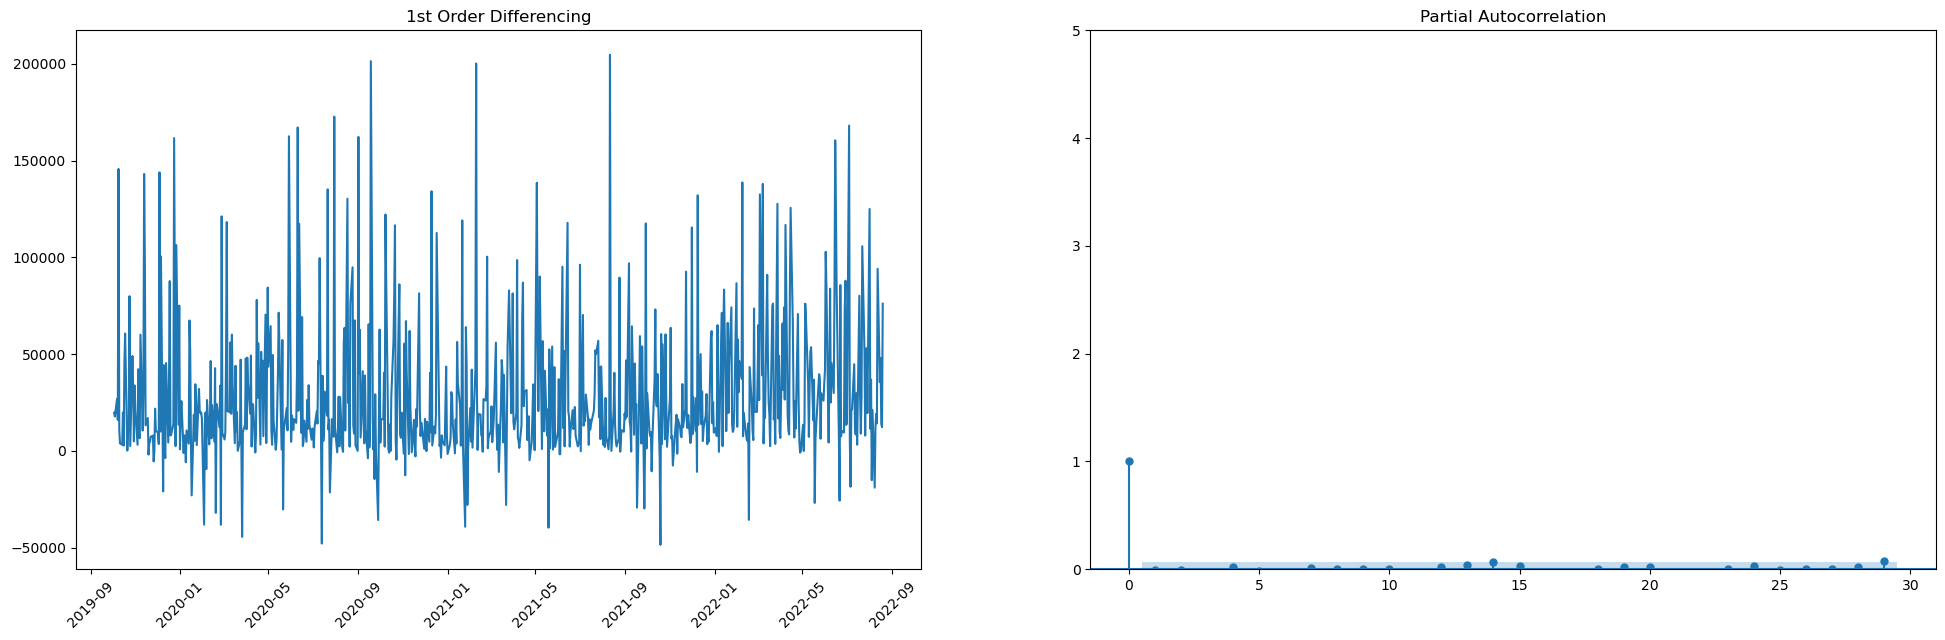

In [26]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(24,7)})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(y_train_total.diff()); axes[0].set_title('1st Order Differencing')
axes[0].tick_params('x', labelrotation=45)
plot_pacf(y_train_total.diff().dropna(), ax=axes[1])
axes[1].set(ylim=(0,5))



The partional autocorrelation plot does not indiate partial autocorrelation of the time series.

### SARIMA with exogoneous variables

In [27]:
# initialize results variables 
smodels       = dict()
res_stats_in  = res_stats_out =  res_stats_out_train_only =pd.DataFrame()

# set the considered currencies
currencies =  ['EUR', 'USD', 'GBP', 'CHF','_Total_']

In [28]:
# run the SARIMA model
# SARIMA stands for Seasonal Autoregression Integrated Moving Average 
# use a seasonal differencing of m=5 for the daily data (there is no data for Saturday and Sunday).
for c in currencies:
    smodels = get_arima(df1_train, smodels, x_vars, c = c, output_folder_model =  output_folder_model)


----------------------------------------------------------------------------------------------------
SARIMA model for EUR

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  753
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -8958.588
Date:                Wed, 07 Jun 2023   AIC                          17933.177
Time:                        16:38:32   BIC                          17970.158
Sample:                    10-02-2019   HQIC                         17947.425
                         - 08-19-2022                                         
Covariance Type:                  opg                                         
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
intercept                    2.754e+04   1341.255   

#### In-Sample performance

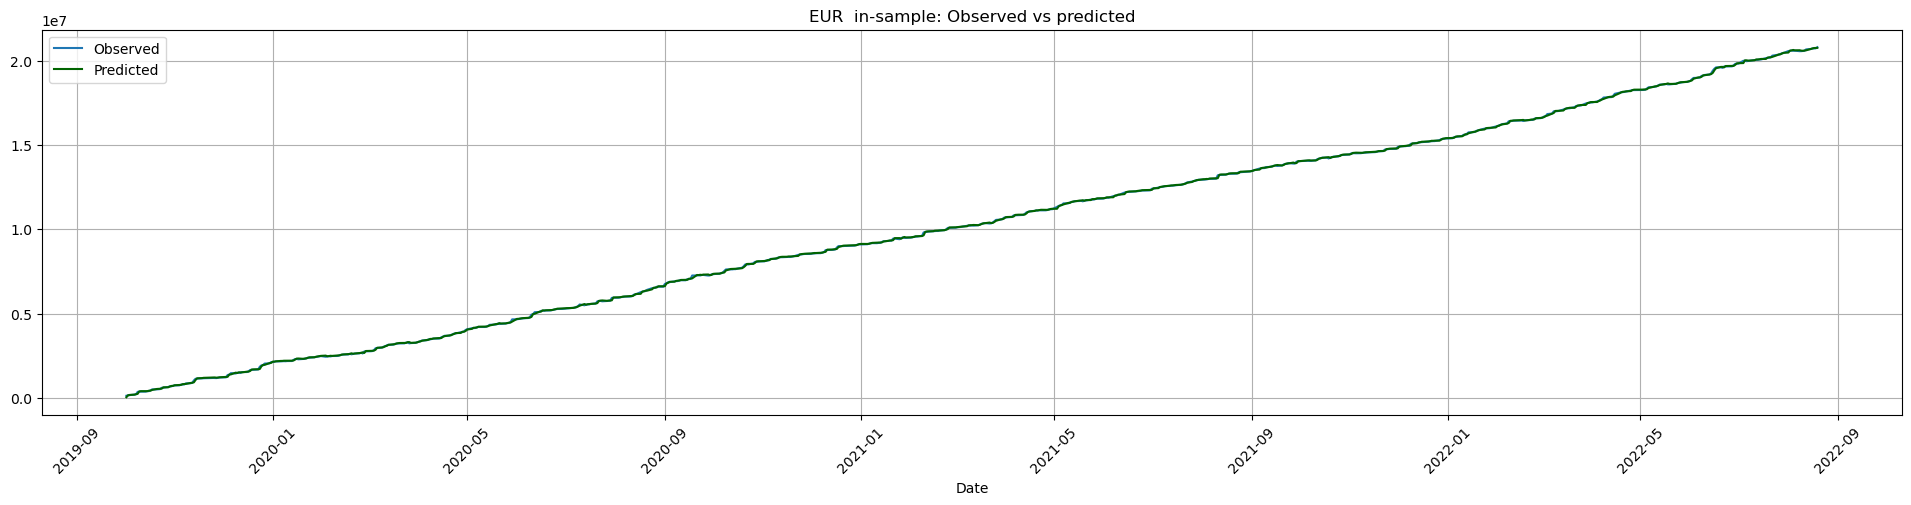

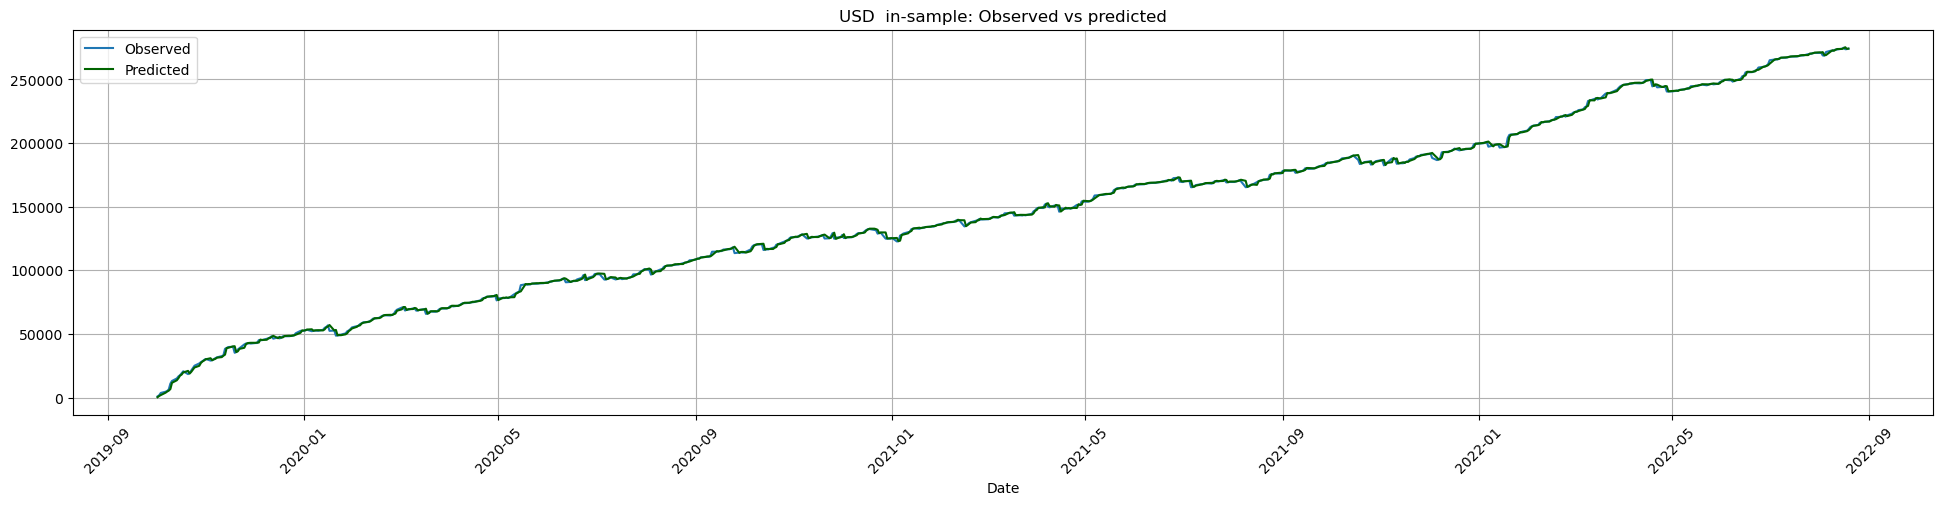

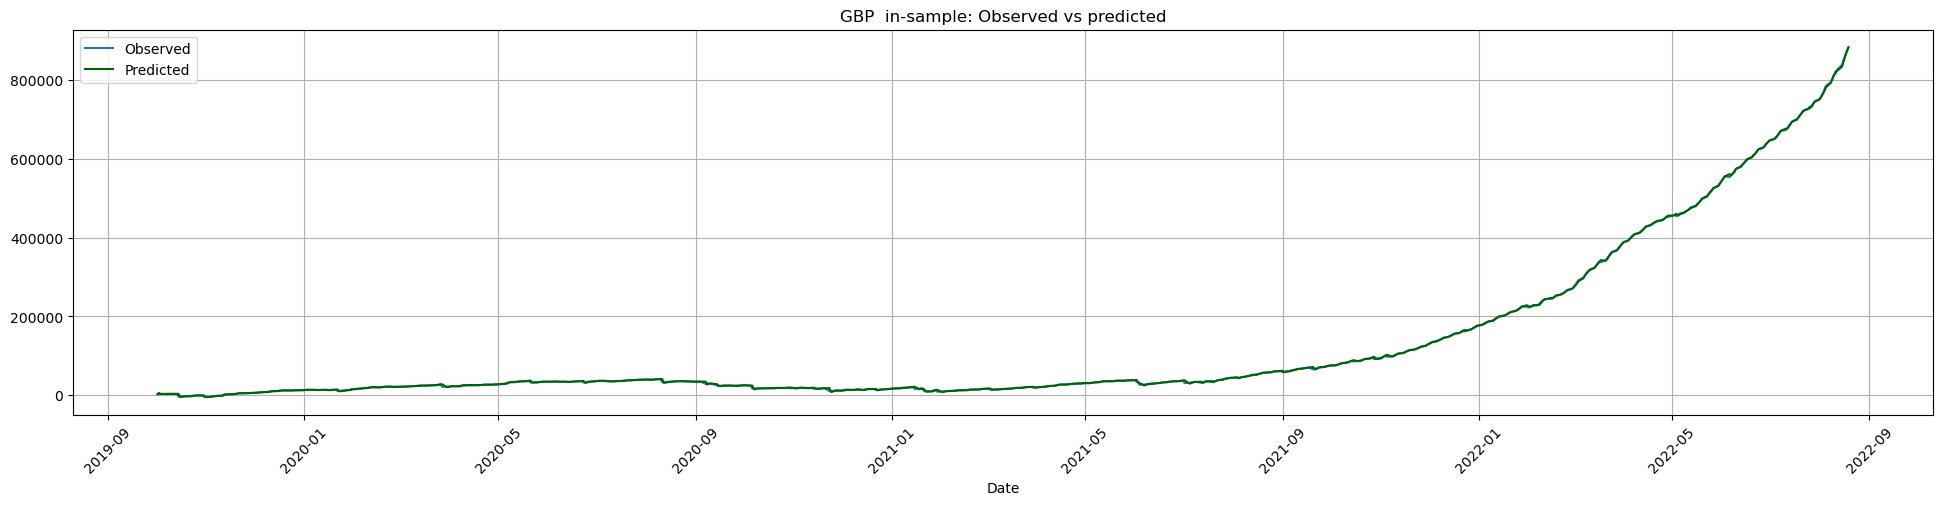

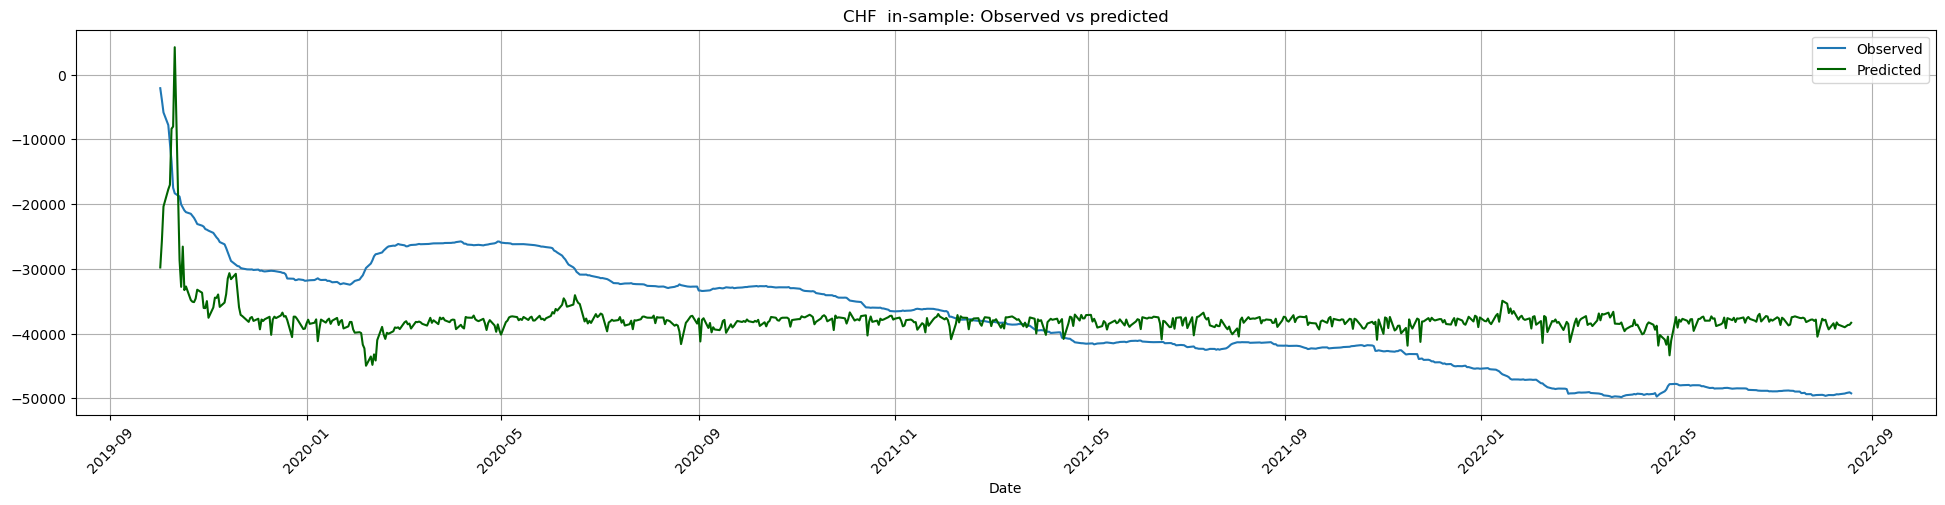

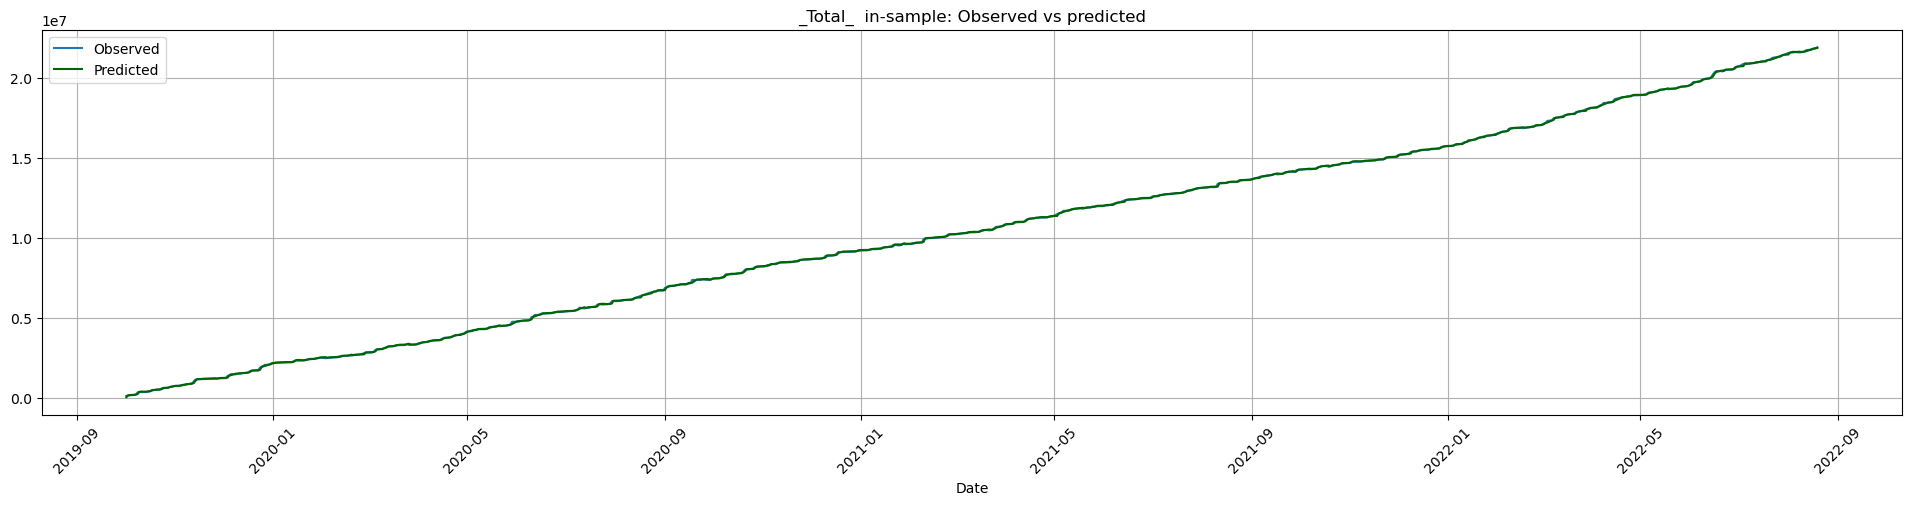

In [31]:
for c in currencies:
    res_stats_in = get_error_stats_in(df1_train, smodels, res_stats_in, x_vars, c = c)

In [32]:
# show in-sample error statistics:
res_stats_in

,EUR,USD,GBP,CHF,_Total_
Root mean squared error,3.621921e+04,1235.356,1388.352,7.821582e+03,3.657618e+04
Mean squared error,1.311831e+09,1526103.453,1927522.061,6.117715e+07,1.337817e+09
Mean absolute error,2.640183e+04,716.835,794.522,6.758930e+03,2.668801e+04
Median absolute error,2.046844e+04,344.998,441.147,6.062397e+03,2.047207e+04
Mean absolute prctg error,7.000000e-03,0.010,0.042,2.210000e-01,7.000000e-03
Explained variance,1.000000e+00,1.000,1.000,1.210000e-01,1.000000e+00
R2,1.000000e+00,1.000,1.000,1.210000e-01,1.000000e+00
Correlation,1.000000e+00,1.000,1.000,3.480000e-01,1.000000e+00


#### Forcast: Out-of-Sample peformance

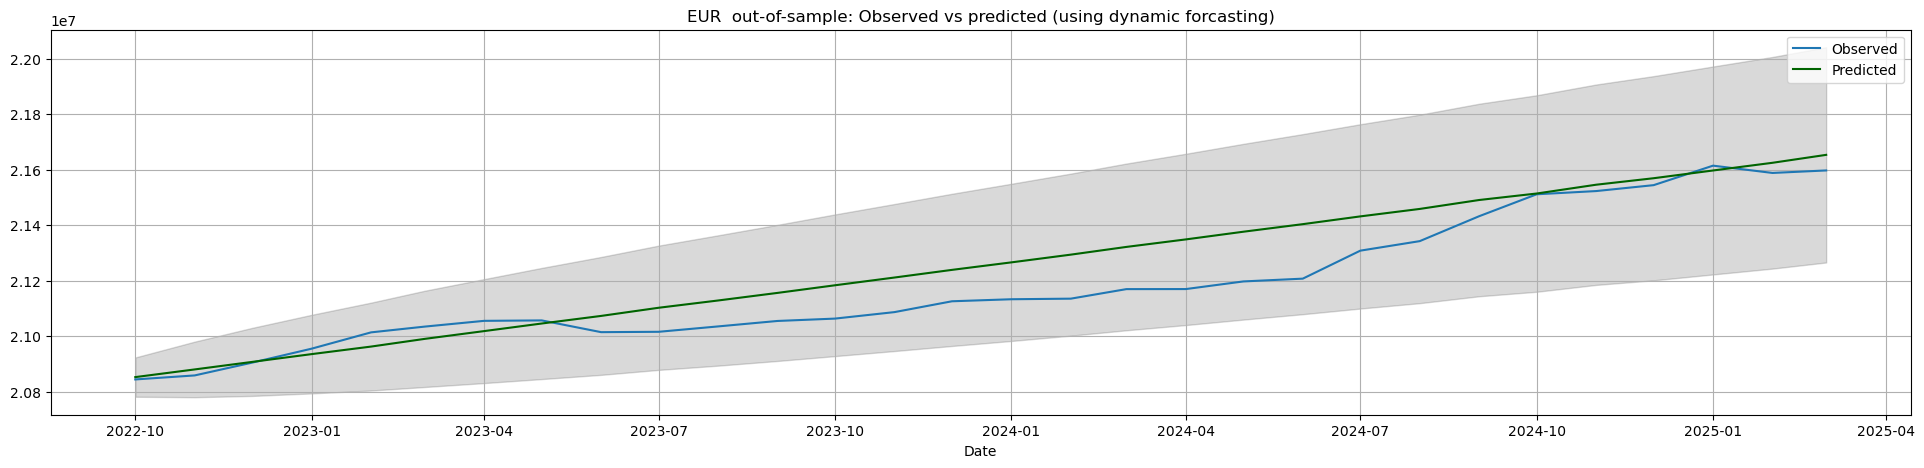

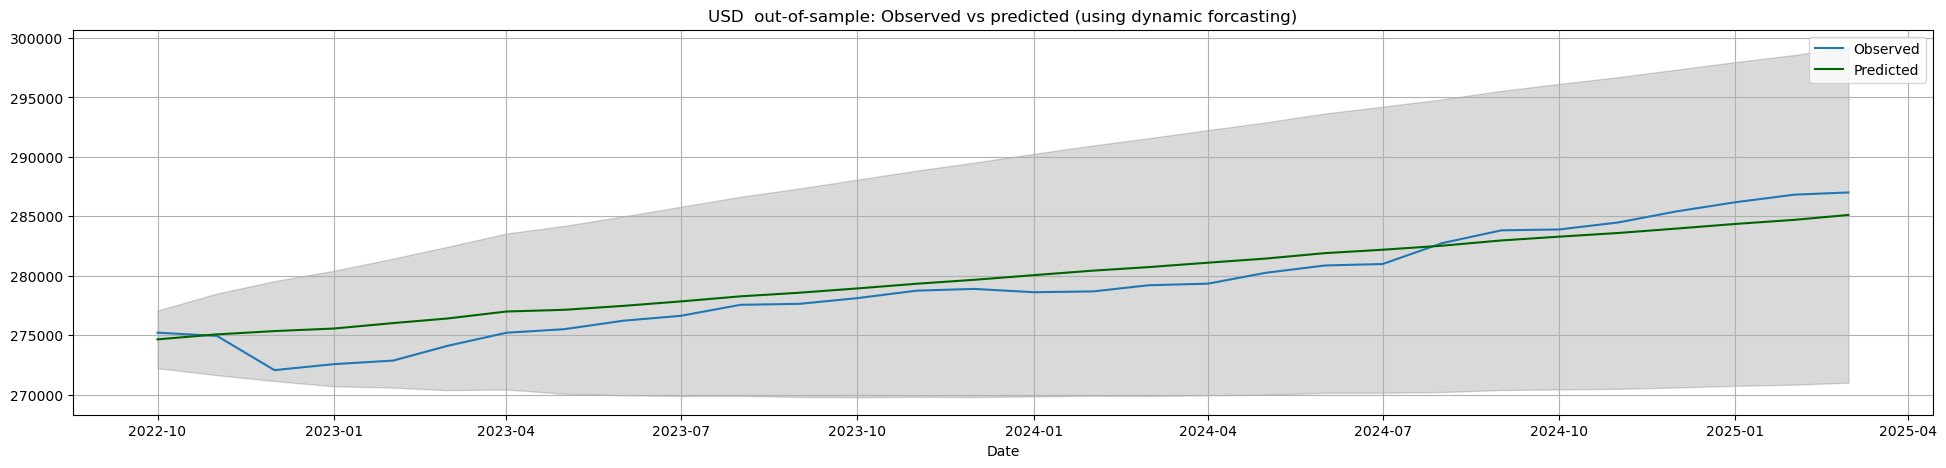

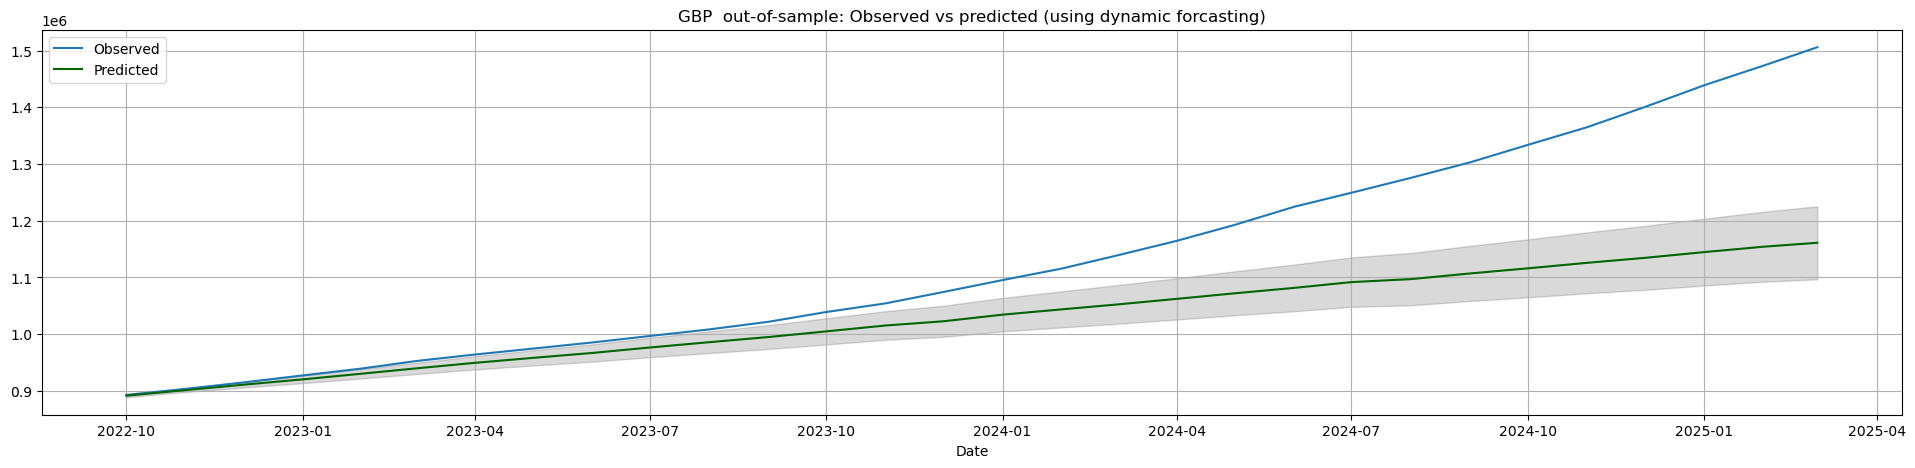

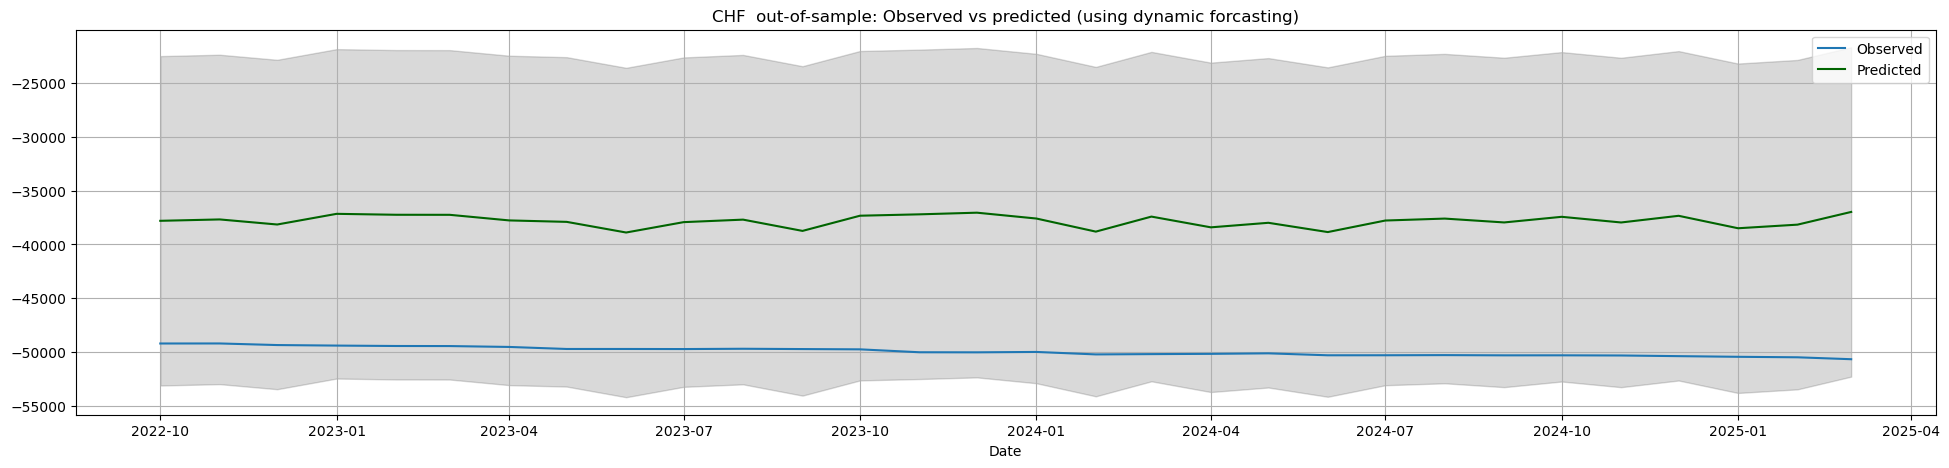

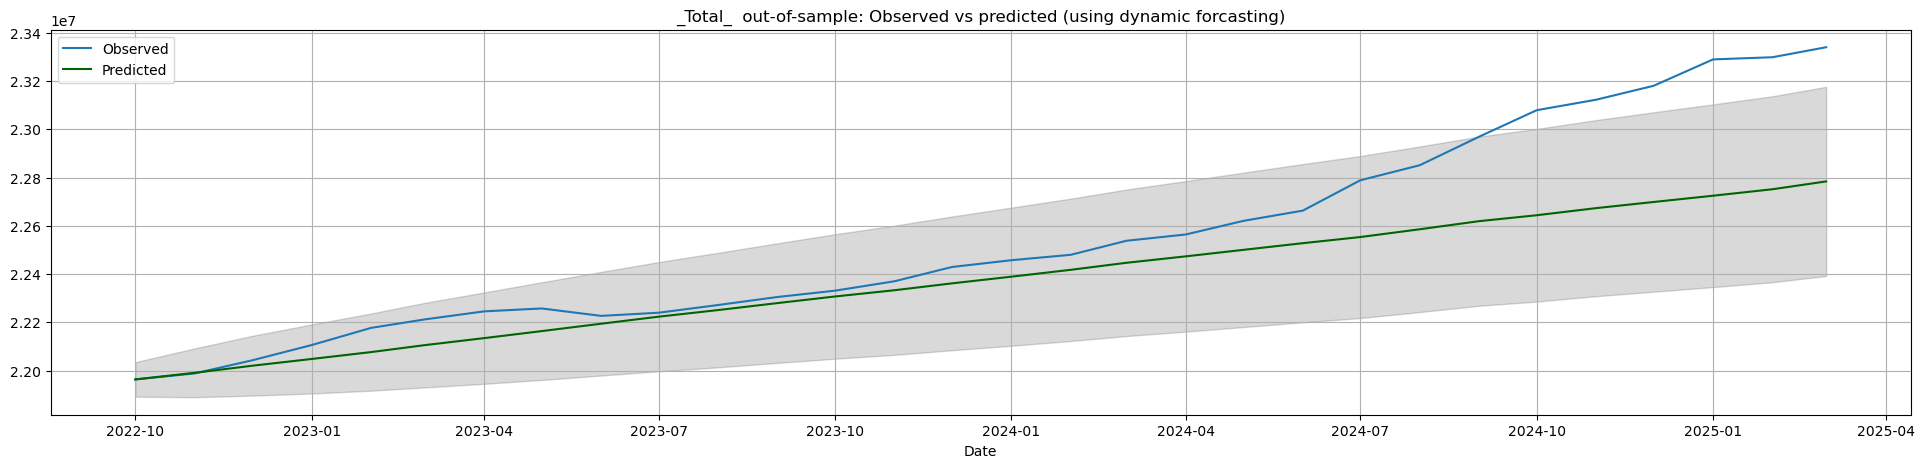

In [33]:
# Using dynamic forcasting:
for c in currencies:    
    res_stats_out = get_error_stats_out(df1_test, smodels, res_stats_out, x_vars, horizon,  c = c)

In [34]:
# show out-of-sample error statistics using dynamic forcasting:
res_stats_out

,EUR,USD,GBP,CHF,_Total_
Root mean squared error,9.761129e+04,1602.945,1.470280e+05,1.216285e+04,2.523804e+05
Mean squared error,9.527963e+09,2569433.242,2.161722e+10,1.479350e+08,6.369586e+10
Mean absolute error,7.826852e+04,1395.113,1.026858e+05,1.214566e+04,1.723009e+05
Median absolute error,5.841033e+04,1229.263,5.630665e+04,1.221274e+04,9.253096e+04
Mean absolute prctg error,4.000000e-03,0.005,7.900000e-02,2.430000e-01,8.000000e-03
Explained variance,9.000000e-01,0.886,6.690000e-01,-1.507000e+00,7.980000e-01
R2,8.140000e-01,0.858,3.540000e-01,-8.861070e+02,6.230000e-01
Correlation,9.540000e-01,0.971,9.770000e-01,1.010000e-01,9.690000e-01


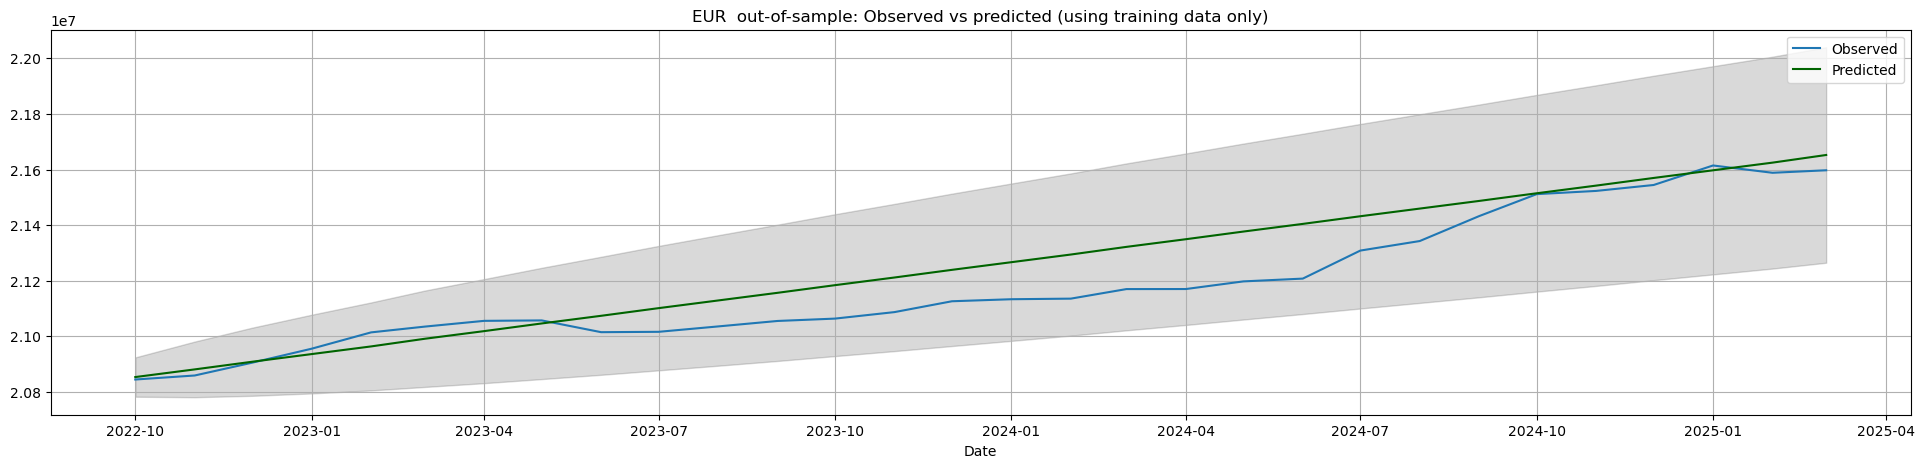

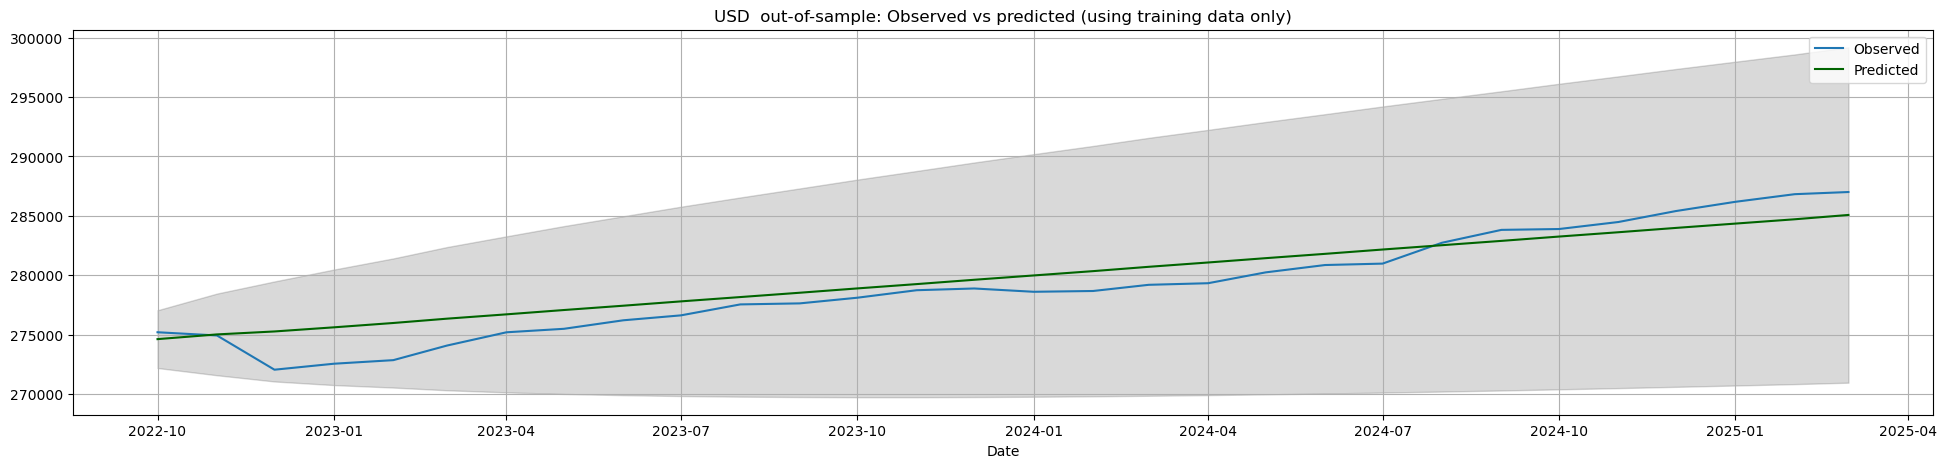

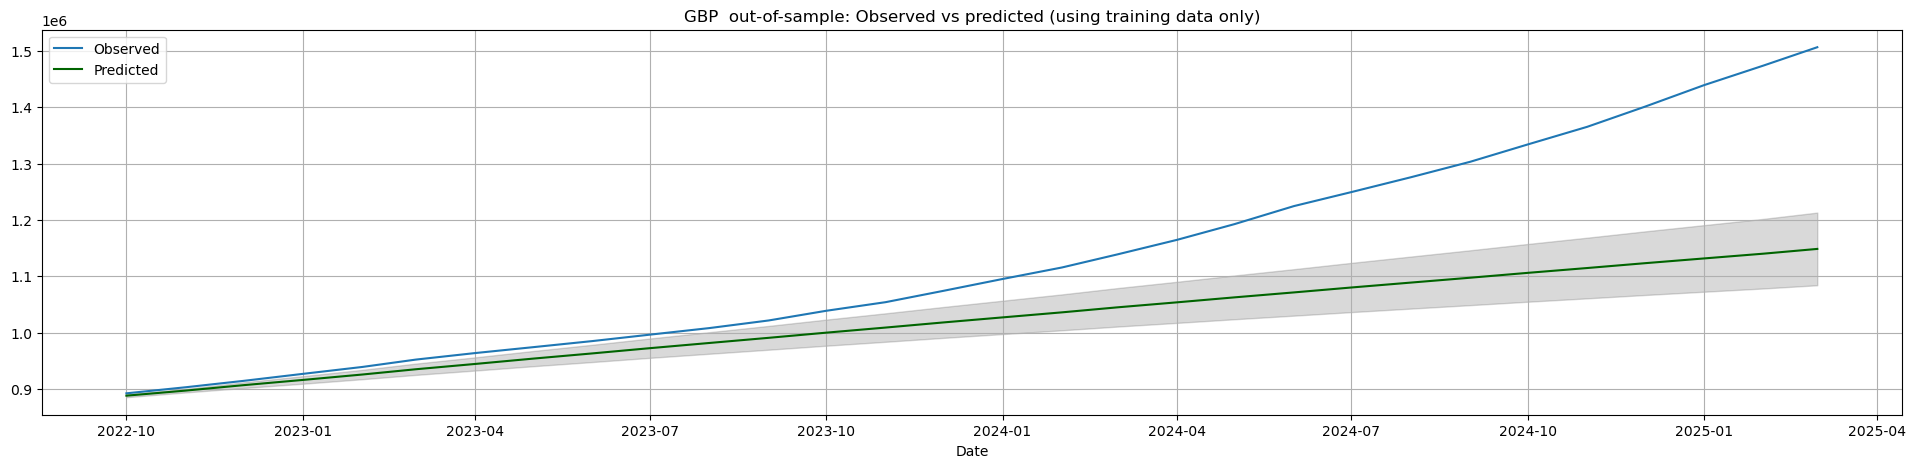

c:\Users\G\anaconda3\envs\py311\Lib\site-packages\scipy\stats\_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


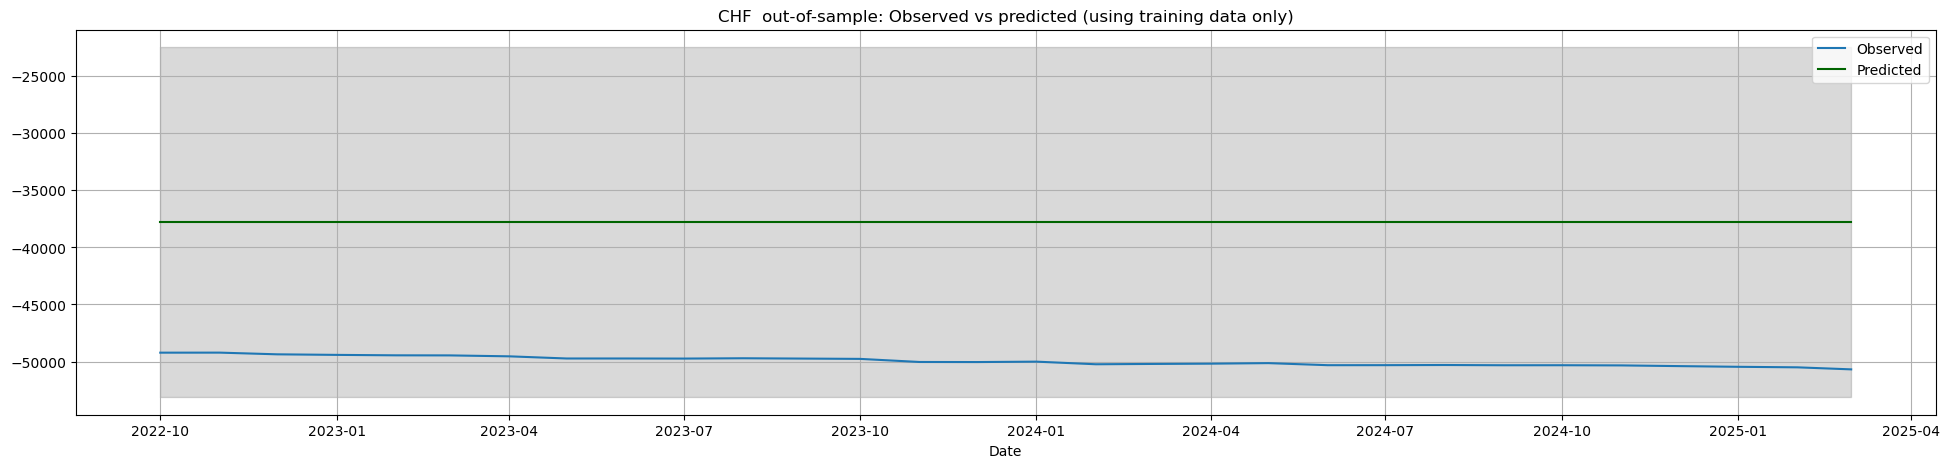

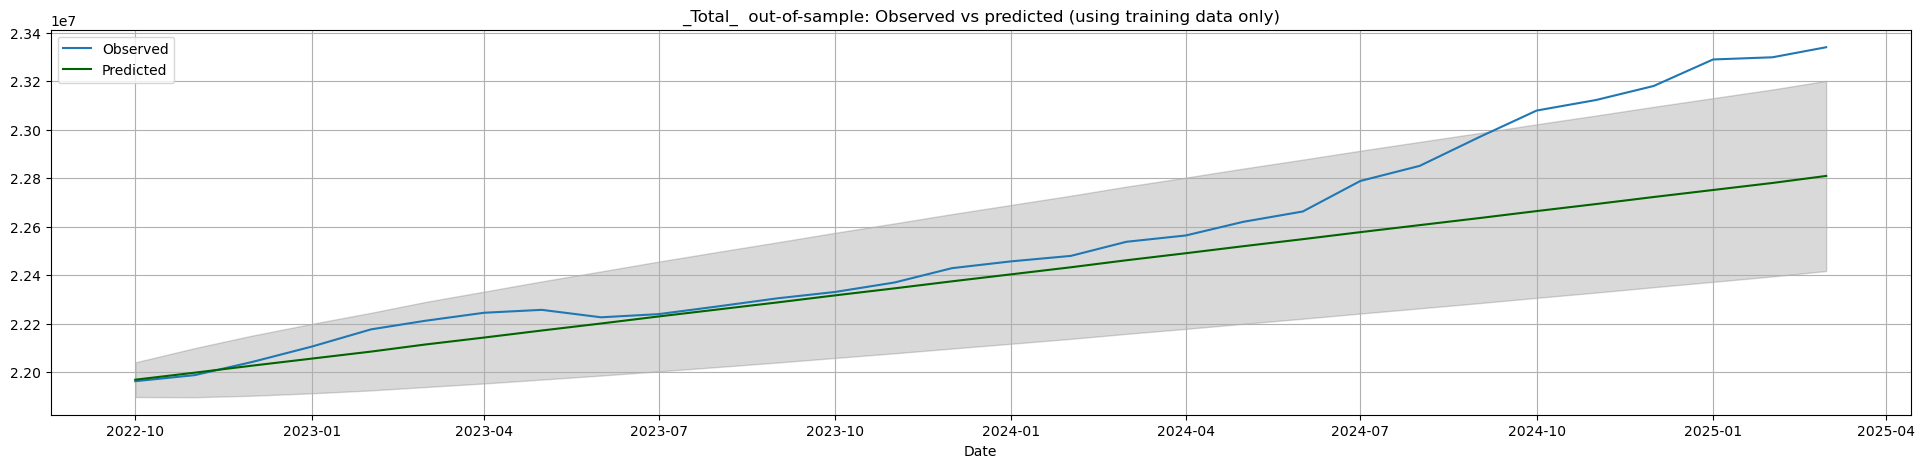

In [35]:
# Using training data only:
for c in currencies:
    res_stats_out_train_only = get_error_stats_out(df1_test, smodels, res_stats_out_train_only, x_vars, horizon, c = c, DYNAMIC_FORCASTING = 0, df1_train = df1_train)

In [36]:
# show out-of-sample error statistics using training data only:
res_stats_out_train_only

,EUR,USD,GBP,CHF,_Total_
Root mean squared error,9.758332e+04,1575.617,1.542361e+05,1.217476e+04,2.381773e+05
Mean squared error,9.522505e+09,2482570.072,2.378877e+10,1.482248e+08,5.672843e+10
Mean absolute error,7.805733e+04,1363.162,1.097054e+05,1.216791e+04,1.584860e+05
Median absolute error,5.695852e+04,1210.713,6.200131e+04,1.224419e+04,8.065128e+04
Mean absolute prctg error,4.000000e-03,0.005,8.500000e-02,2.430000e-01,7.000000e-03
Explained variance,8.990000e-01,0.887,6.490000e-01,-0.000000e+00,8.110000e-01
R2,8.140000e-01,0.863,2.890000e-01,-8.878450e+02,6.640000e-01
Correlation,9.540000e-01,0.971,9.750000e-01,NaN,9.700000e-01


### Long Short-Term Memory Network

The Long Short-Term Memory network is a recurrent neural network.

LSTM networks use memory blocks - instead of neurons - connected through layers.

A block has components that make it smarter than a classical neuron and a memory for recent sequences. A block contains gates that manage the block’s state and output. A block operates upon an input sequence, and each gate within a block uses the sigmoid activation units to control whether it is triggered or not, making the change of state and addition of information flowing through the block conditional.

There are three types of gates within a unit:

*    Forget Gate: conditionally decides what information to throw away from the block
*    Input Gate: conditionally decides which values from the input to update the memory state
*    Output Gate: conditionally decides what to output based on input and the memory of the block


In [159]:
# setup 
x_vars_plus = x_vars +['y_var_lagged1']


print(x_vars_plus)

# set the considered currencies
currencies =  ['EUR']#['EUR', 'USD', 'GBP', 'CHF','_Total_']

# initialize results variables 
rnn_results       = dict()
res_stats_in_rnn  = res_stats_out_rnn  =pd.DataFrame()

from utility import *
# reload functions from utility
from importlib import reload
reload(sys.modules['utility'])

['ChangeRequestCosts_lagged1', 'AdministrationCosts_lagged1', 'OverheadCosts_lagged1', 'Interests_lagged1', 'Revenue_lagged1', 'Profit_lagged1', 'y_var_lagged1']


<module 'utility' from 'C:\\DEV/portfolio/src//utils\\utility.py'>

In [160]:
# get the lstm model(s):
for c in currencies:
    rnn_results[c] = get_lstm(df1_train, df1_test, x_vars_plus, c = c, PRINT = 1, LOAD = 1,  output_folder_model = output_folder_model)
 


----------------------------------------------------------------------------------------------------
LSTM RNN model for EUR

1/1 [==============================] - 0s 55ms/step


### In-Sample Performance

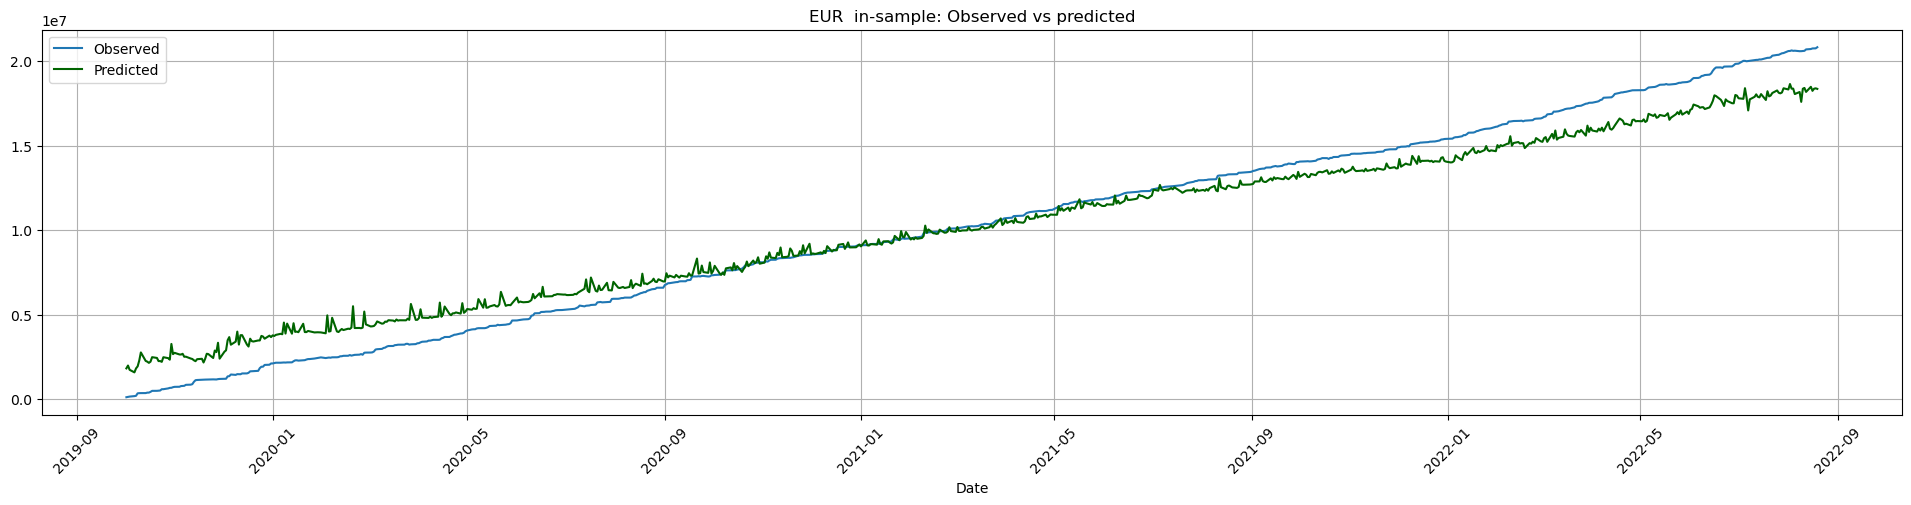

In [161]:
# plot Actual vs Fitted
for c in currencies:
    plot_observed_vs_predicted(rnn_results[c]['y_train'], rnn_results[c]['trainPredict'], title1 = c+'  in-sample: Observed vs predicted')

In [162]:
# Error Statistics
for c in currencies:
    res_stats_in_rnn[c] = error_statistics(rnn_results[c]['y_train'], rnn_results[c]['trainPredict'],colname=c)
res_stats_in_rnn    

,EUR
Root mean squared error,1.239793e+06
Mean squared error,1.537087e+12
Mean absolute error,1.025572e+06
Median absolute error,1.023494e+06
Mean absolute prctg error,3.710000e-01
Explained variance,9.550000e-01
R2,9.550000e-01
Correlation,9.990000e-01


### Forcast: Out-of-sample

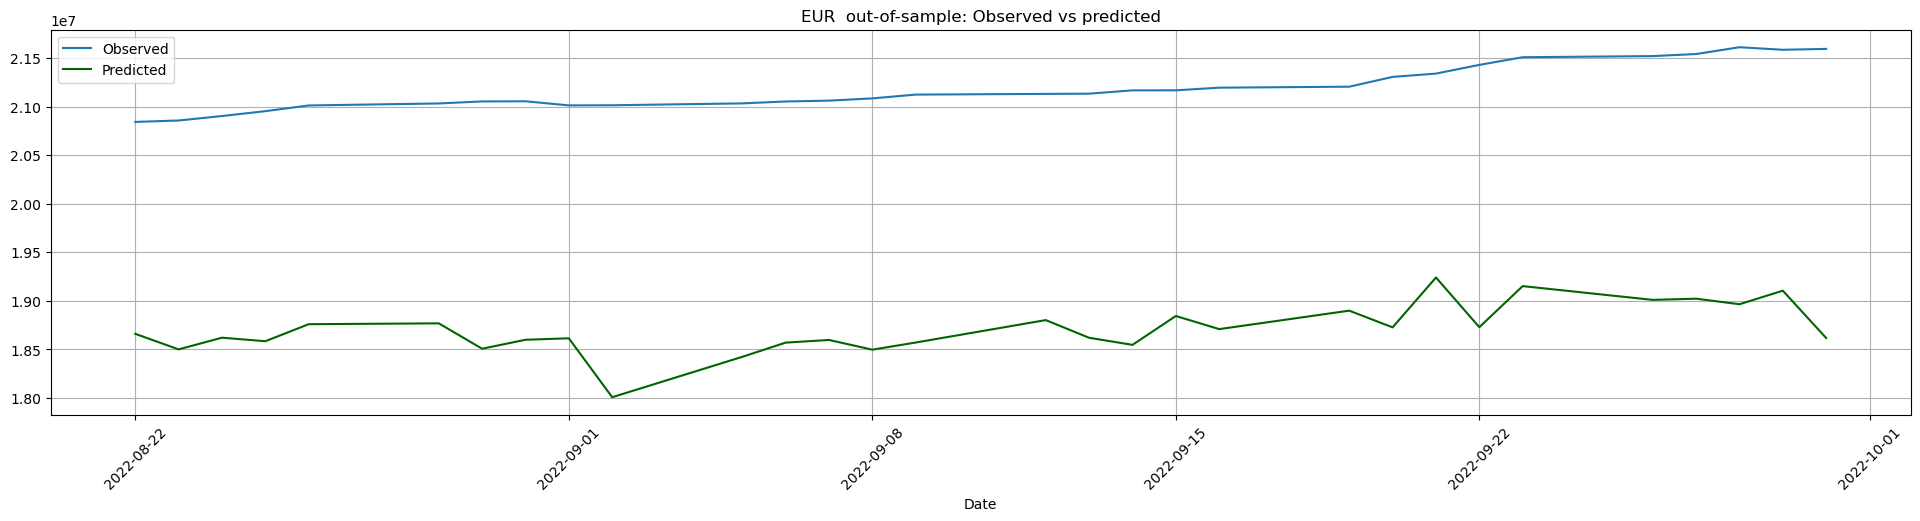

In [163]:
for c in currencies:
    plot_observed_vs_predicted(rnn_results[c]['y_test'], rnn_results[c]['testPredict'], title1 = c+'  out-of-sample: Observed vs predicted')

In [164]:
# Error Statistics
for c in currencies:
    res_stats_in_rnn[c] = error_statistics(rnn_results[c]['y_test'], rnn_results[c]['testPredict'],colname=c)
res_stats_in_rnn  


,EUR
Root mean squared error,2.485728e+06
Mean squared error,6.178845e+12
Mean absolute error,2.477857e+06
Median absolute error,2.484465e+06
Mean absolute prctg error,1.170000e-01
Explained variance,2.370000e-01
R2,-1.196690e+02
Correlation,6.510000e-01
